# Enefit - Predict Energy Behavior of Prosumers

The challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. The dataset includes weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

This is a forecasting competition using the time series API.

**Description**

The number of prosumers is rapidly increasing, and solving the problems of energy imbalance and their rising costs is vital. If left unaddressed, this could lead to increased operational costs, potential grid instability, and inefficient use of energy resources. If this problem were effectively solved, it would significantly reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable. Moreover, it could potentially incentivize more consumers to become prosumers, knowing that their energy behavior can be adequately managed, thus promoting renewable energy production and use.

**About us**

Enefit is one of the biggest energy companies in Baltic region. As experts in the field of energy, we help customers plan their green journey in a personal and flexible manner as well as implement it by using environmentally friendly energy solutions.
At present, Enefit is attempting to solve the imbalance problem by developing internal predictive models and relying on third-party forecasts. However, these methods have proven to be insufficient due to their low accuracy in forecasting the energy behavior of prosumers. The shortcomings of these current methods lie in their inability to accurately account for the wide range of variables that influence prosumer behavior, leading to high imbalance costs. By opening up the challenge to the world's best data scientists through the Kaggle platform, Enefit aims to leverage a broader pool of expertise and novel approaches to improve the accuracy of these predictions and consequently reduce the imbalance and associated costs.

**Evaluation**

Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:

𝑀𝐴𝐸=1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑥𝑖|

Where:
* 𝑛 is the total number of data points.
* 𝑦𝑖 is the predicted value for data point i.
* 𝑥𝑖 is the observed value for data point i.

**Submitting**

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow the template in this [notebook](https://www.kaggle.com/code/sohier/enefit-basic-submission-demo).

**Timeline**

This is a future data prediction competition with an active training phase and a second period where selected submissions will be evaluated against future ground truth data.

*Training Timeline*

* November 1, 2023 - Start Date.
* January 24, 2024 - Entry Deadline. You must accept the competition rules before this date in order to compete.
* January 24, 2024 - Team Merger Deadline. This is the last day participants may join or merge teams.
* January 31, 2024 - Final Submission Deadline.

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

*Prediction Timeline:*

Starting after the final submission deadline there will be periodic updates to the leaderboard to reflect future data updates that will be evaluated against selected submissions. We anticipate 1-3 interim updates before the final evaluation.

* April 30, 2024 - Competition End Date

**Prizes**

* 1st Place - $ 15,000
* 2nd Place - $ 10,000
* 3rd Place - $ 8,000
* 4th Place - $ 7,000
* 5th Place - $ 5,000
* 6th Place - $ 5,000

**Code Requirements**

Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

* CPU Notebook <= 9 hours run-time
* GPU Notebook <= 9 hours run-time
* Internet access disabled
* Freely & publicly available external data is allowed, including pre-trained models
* Submission file must be named submission.csv and be generated by the API.

Please see the [Code Competition FAQ](https://www.kaggle.com/docs/competitions#notebooks-only-FAQ) for more information on how to submit. And review the [code debugging doc](https://www.kaggle.com/code-competition-debugging) if you are encountering submission errors.

### Load Workspace

In [1]:
import re
import datetime as dt
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
import seaborn as sns
import opendatasets as od
import kaggle
import zipfile
import io
import json
import warnings

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import notebook
from itertools import product
from typing import Union

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report

### Load Data

In [2]:
def list_files_in_zip(zip_file_path):
    zip_files = list()
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file in file_list:
            zip_files.append(file)
    return zip_files

zip_file_path = 'predict-energy-behavior-of-prosumers.zip'

enefit_files = list_files_in_zip(zip_file_path)
enefit_files

['client.csv',
 'county_id_to_name_map.json',
 'electricity_prices.csv',
 'enefit/__init__.py',
 'enefit/competition.cpython-310-x86_64-linux-gnu.so',
 'example_test_files/client.csv',
 'example_test_files/electricity_prices.csv',
 'example_test_files/forecast_weather.csv',
 'example_test_files/gas_prices.csv',
 'example_test_files/historical_weather.csv',
 'example_test_files/revealed_targets.csv',
 'example_test_files/sample_submission.csv',
 'example_test_files/test.csv',
 'forecast_weather.csv',
 'gas_prices.csv',
 'historical_weather.csv',
 'public_timeseries_testing_util.py',
 'train.csv',
 'weather_station_to_county_mapping.csv']

In [3]:
def read_csv_from_zip(zip_file_path, csv_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(csv_file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            return df

def read_json_from_zip(zip_file_path, json_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(json_file_name) as file:
            data = json.load(file)
            df = pd.DataFrame(data, index=range(len(data)))
            return df
        
def clean_date(df):
    date_cols = ['date', 'datetime', 'forecast_date', 'origin_date', 'forecast_datetime', 'origin_datetime']
    for col in df.columns:
        if col in date_cols:
            df[col] = pd.to_datetime(df[col])
    return df

In [4]:
enefit_dict = dict()
keys = [
    'county_id_to_name_map',
    'gas_prices', 'historical_weather',
    'weather_station_to_county_mapping'
]

In [5]:
for key in keys:
    if key + '.csv' in enefit_files:
        csv_file_name = key + '.csv'
        enefit_dict[key] = read_csv_from_zip(zip_file_path, csv_file_name)
        enefit_dict[key] = clean_date(enefit_dict[key])
    elif key + '.json' in enefit_files:
        json_file_name = key + '.json'
        enefit_dict[key] = read_json_from_zip(zip_file_path, json_file_name)

In [6]:
print(enefit_dict['gas_prices'].info)
print(enefit_dict['historical_weather'].info)

In [7]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

**Gas Prices**

The features in this dataset are:
* origin_date - The date when the day-ahead prices became available.
* forecast_date - The date when the forecast prices should be relevant.
* [lowest/highest]_price_per_mwh - The lowest/highest price of natural gas that on the day ahead market that trading day, in Euros per megawatt hour equivalent.
* data_block_id

In [8]:
enefit_dict['gas_prices'].head()

forecast_date  lowest_price_per_mwh  highest_price_per_mwh origin_date  \
0    2021-09-01                 45.23                  46.32  2021-08-31   
1    2021-09-02                 45.62                  46.29  2021-09-01   
2    2021-09-03                 45.85                  46.40  2021-09-02   
3    2021-09-04                 46.30                  46.80  2021-09-03   
4    2021-09-05                 46.30                  46.58  2021-09-04   

   data_block_id  
0              1  
1              2  
2              3  
3              4  
4              5

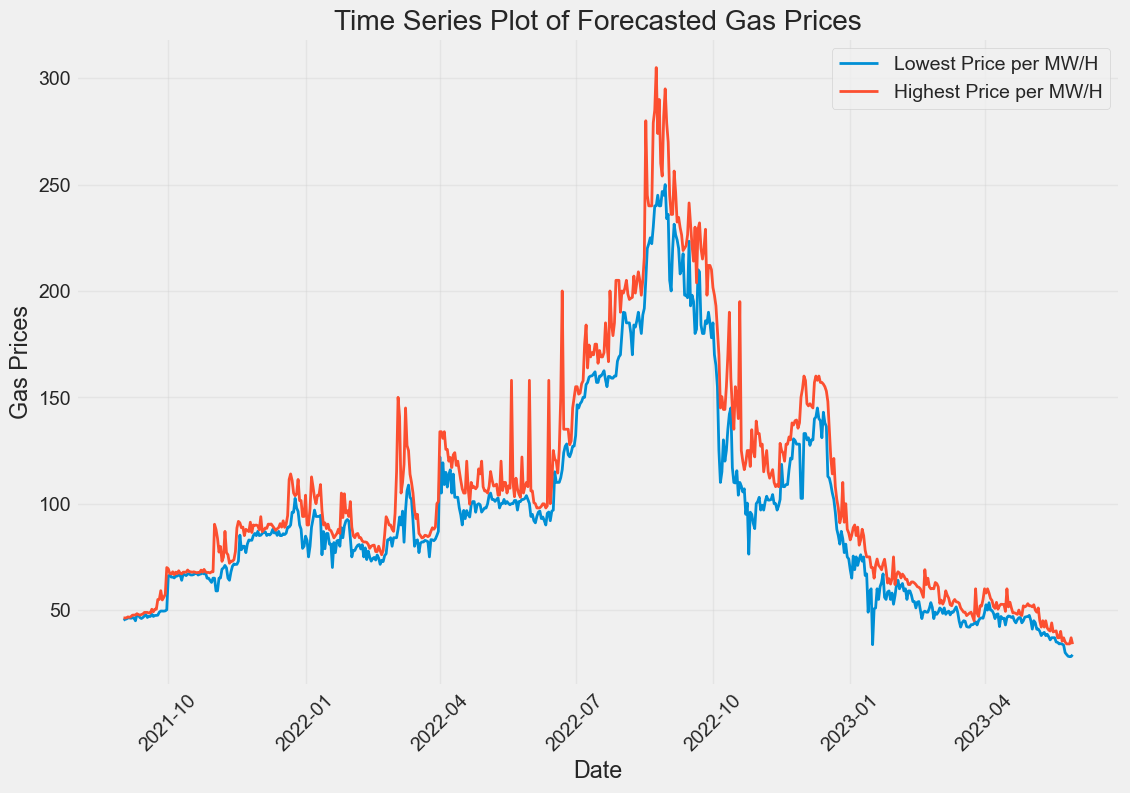

In [9]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    x='forecast_date', y='lowest_price_per_mwh',
    data=enefit_dict['gas_prices'],
    estimator='mean', size=.7,
    legend='brief', label='Lowest Price per MW/H'
)
sns.lineplot(
    x='forecast_date', y='highest_price_per_mwh',
    data=enefit_dict['gas_prices'],
    estimator='mean', size=.7,
    legend='brief', label='Highest Price per MW/H'
)
plt.xlabel('Date')
plt.ylabel('Gas Prices')
plt.title('Time Series Plot of Forecasted Gas Prices')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend()

plt.show()

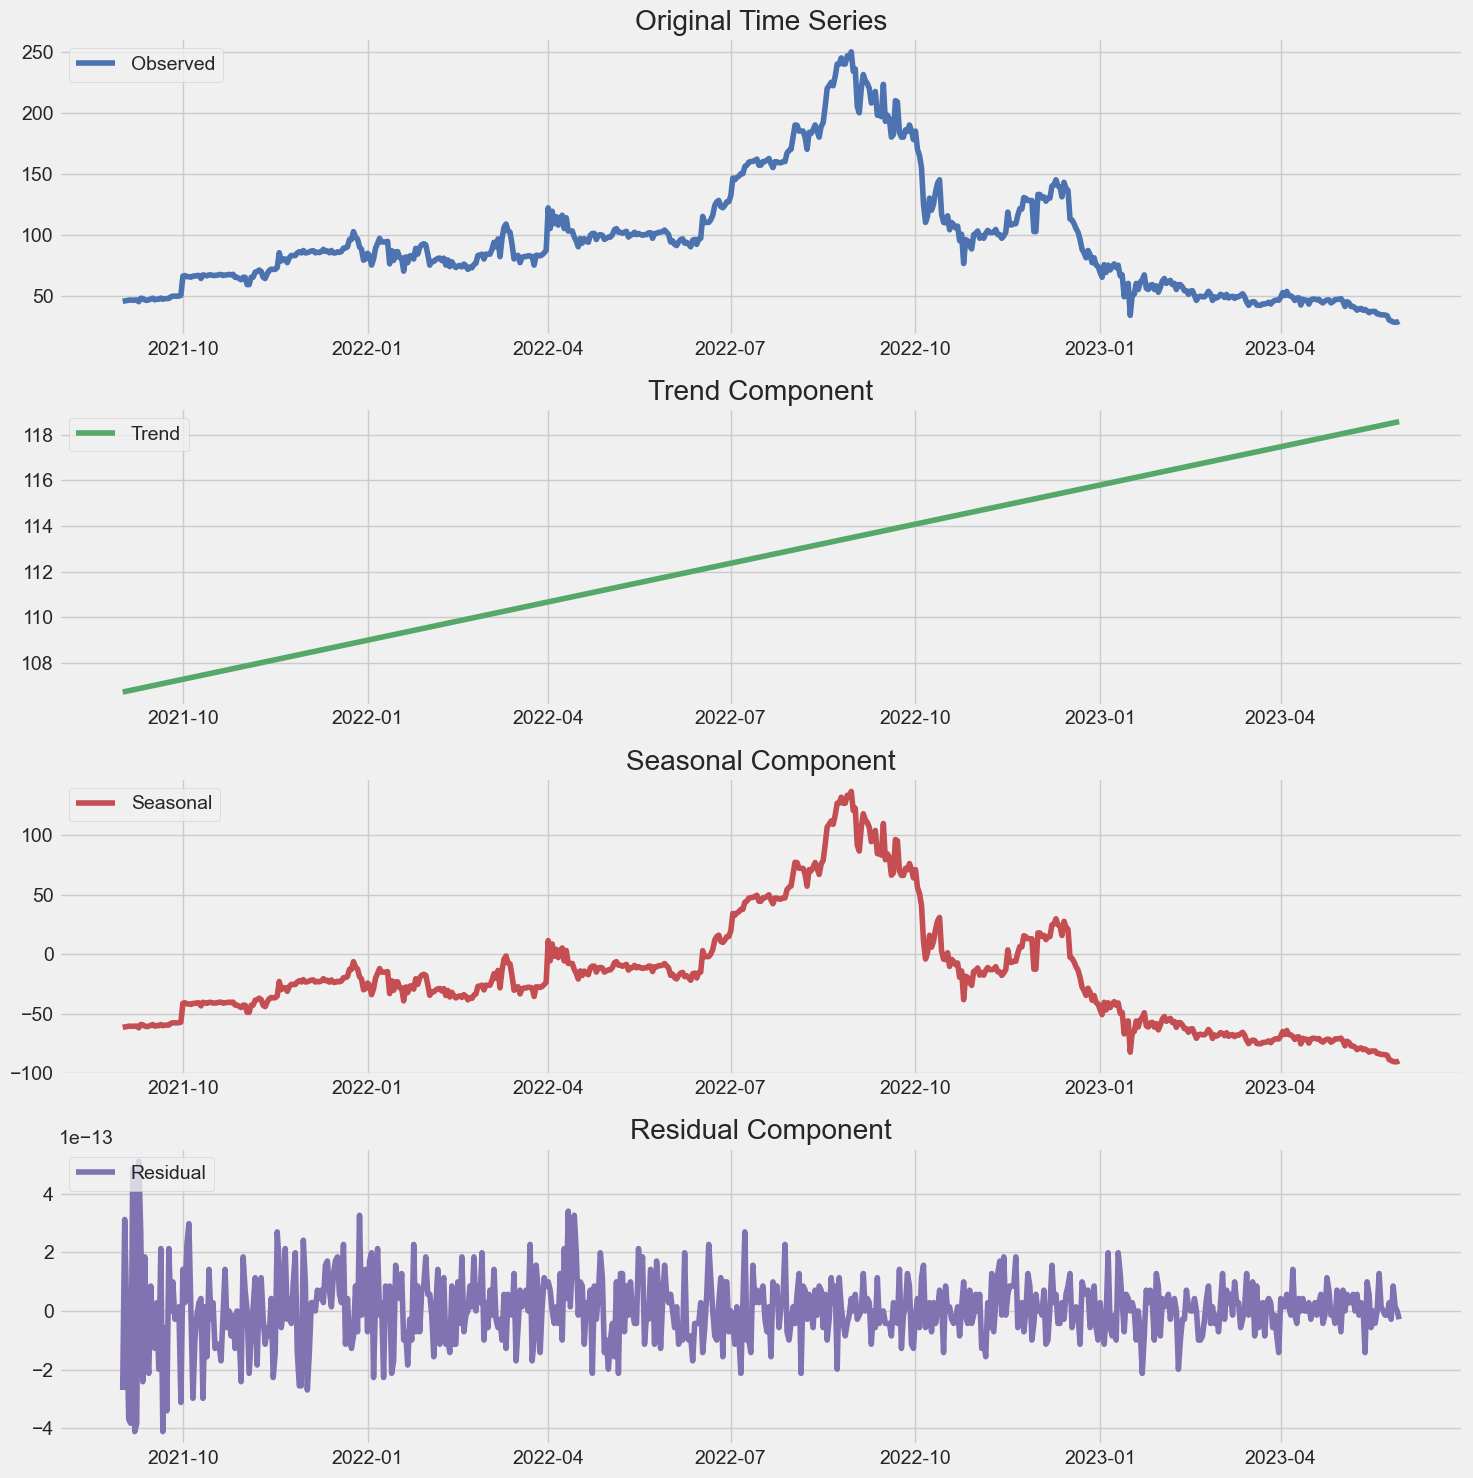

In [10]:
# 365D Period
decomposition = STL(enefit_dict['gas_prices'].set_index('forecast_date').lowest_price_per_mwh.asfreq('D'), period=365).fit()
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original time series
plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(observed, label='Observed', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

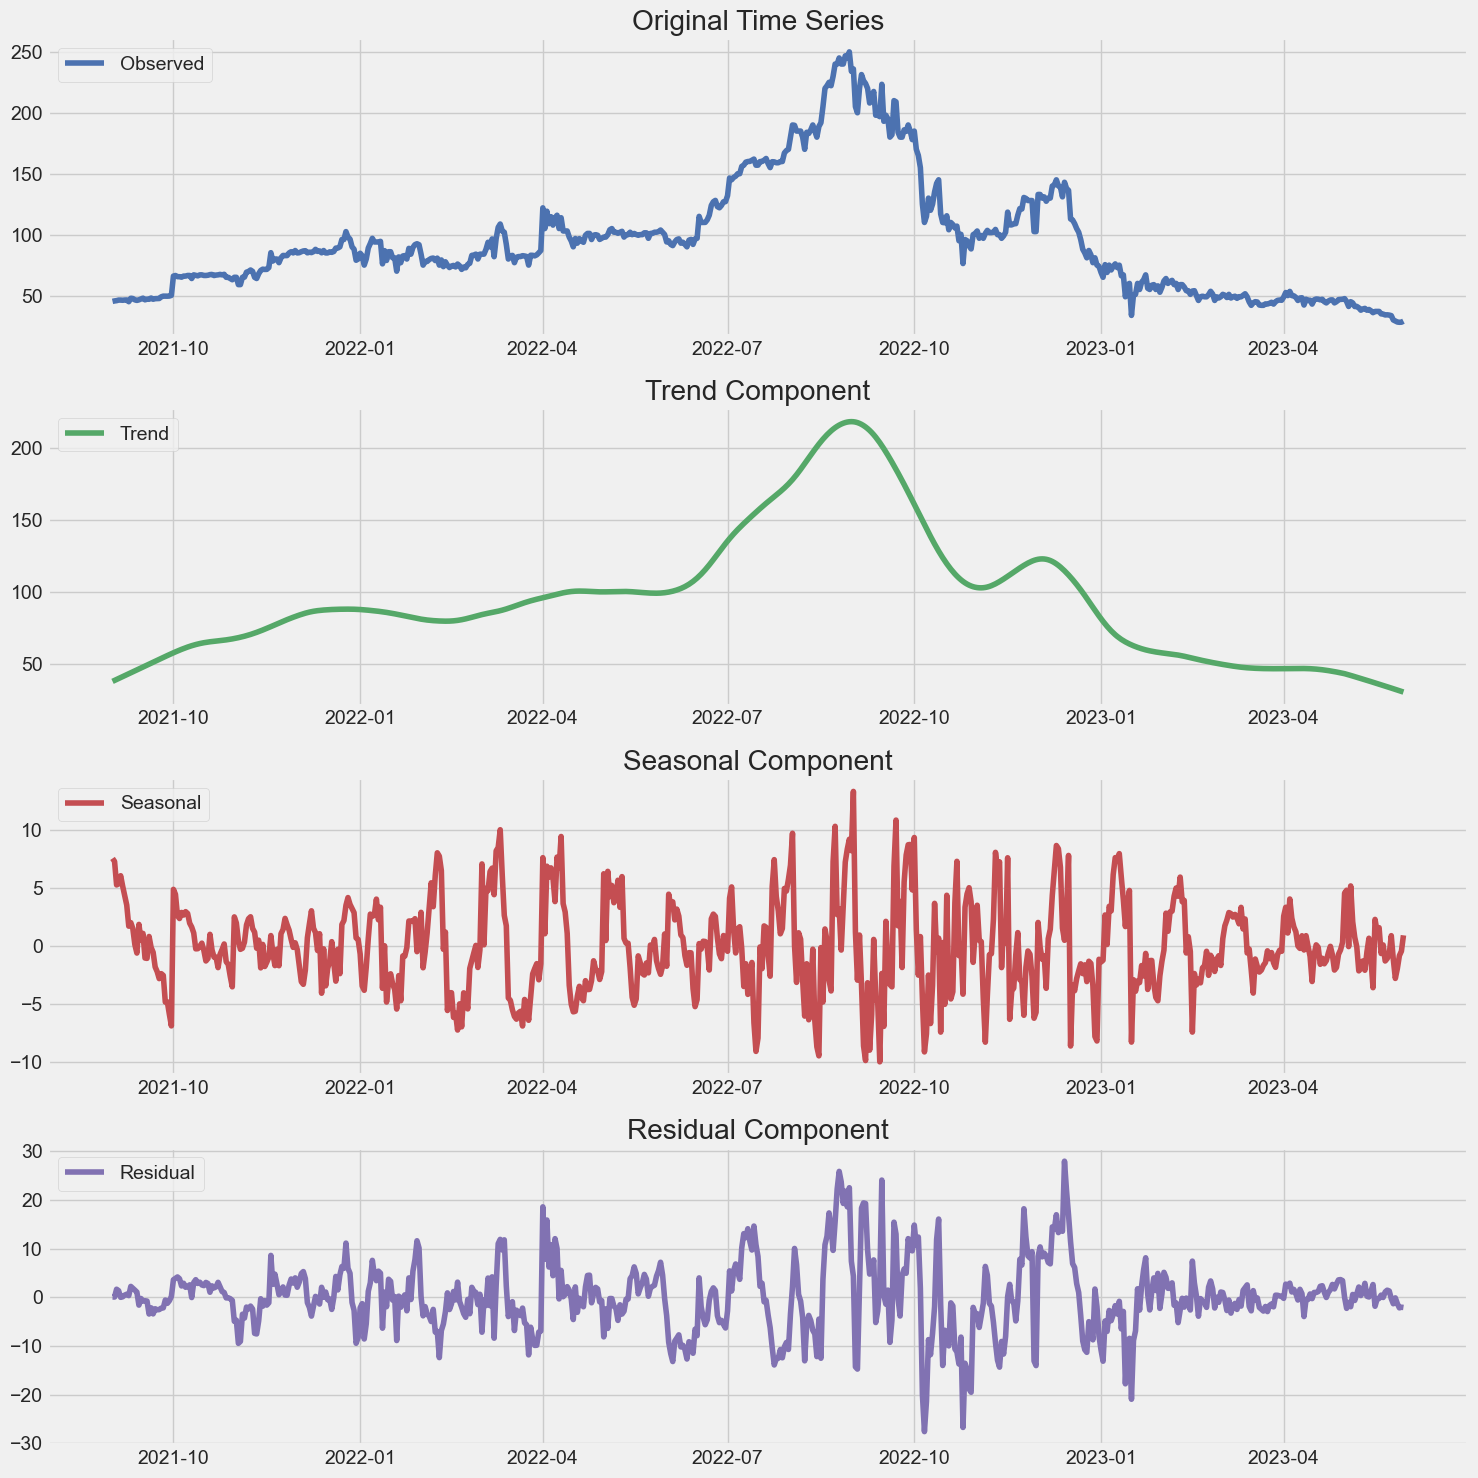

In [11]:
# 30D Period
decomposition = STL(enefit_dict['gas_prices'].set_index('forecast_date').lowest_price_per_mwh.asfreq('D'), period=30).fit()
observed2 = decomposition.observed
trend2 = decomposition.trend
seasonal2 = decomposition.seasonal
residual2 = decomposition.resid

# Plot the original time series
plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(observed2, label='Observed', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend2, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal2, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual2, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

**Analyzing Trend Component**

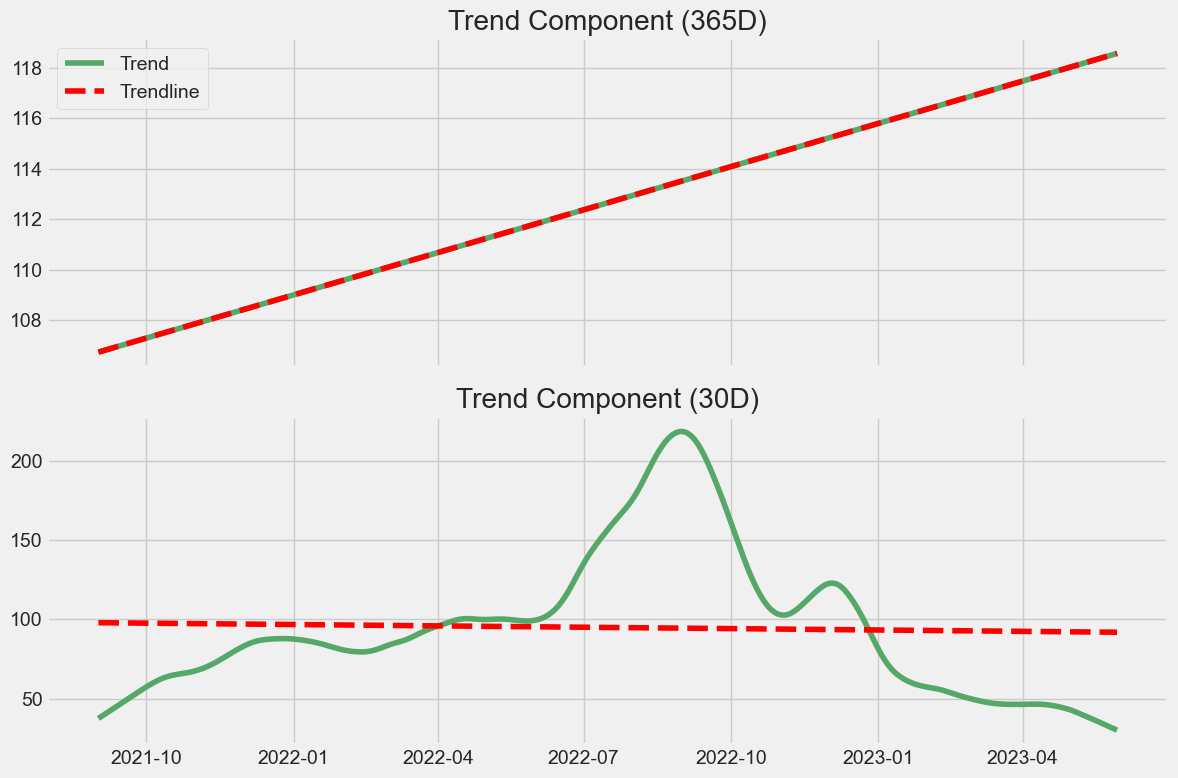

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

ax1.plot(trend, label='Trend', color=deep_colors[1])
# Fit a linear regression trend-line
x_values = pd.to_numeric(trend.index) / 10**9
coefficients = np.polyfit(x_values, trend.fillna(0), 1)
slope, intercept = coefficients
trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)

ax1.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')
ax1.legend(loc='upper left')
ax1.set_title('Trend Component (365D)')


ax2.plot(trend2, label='Trend', color=deep_colors[1])
# Fit a linear regression trend-line
x_values = pd.to_numeric(trend2.index) / 10**9
coefficients = np.polyfit(x_values, trend2.fillna(0), 1)
slope, intercept = coefficients
trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)

ax2.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')
# ax2.legend(loc='upper left')
ax2.set_title('Trend Component (30D)')

plt.tight_layout()
plt.show()

**Analyzing Seasonal Component**

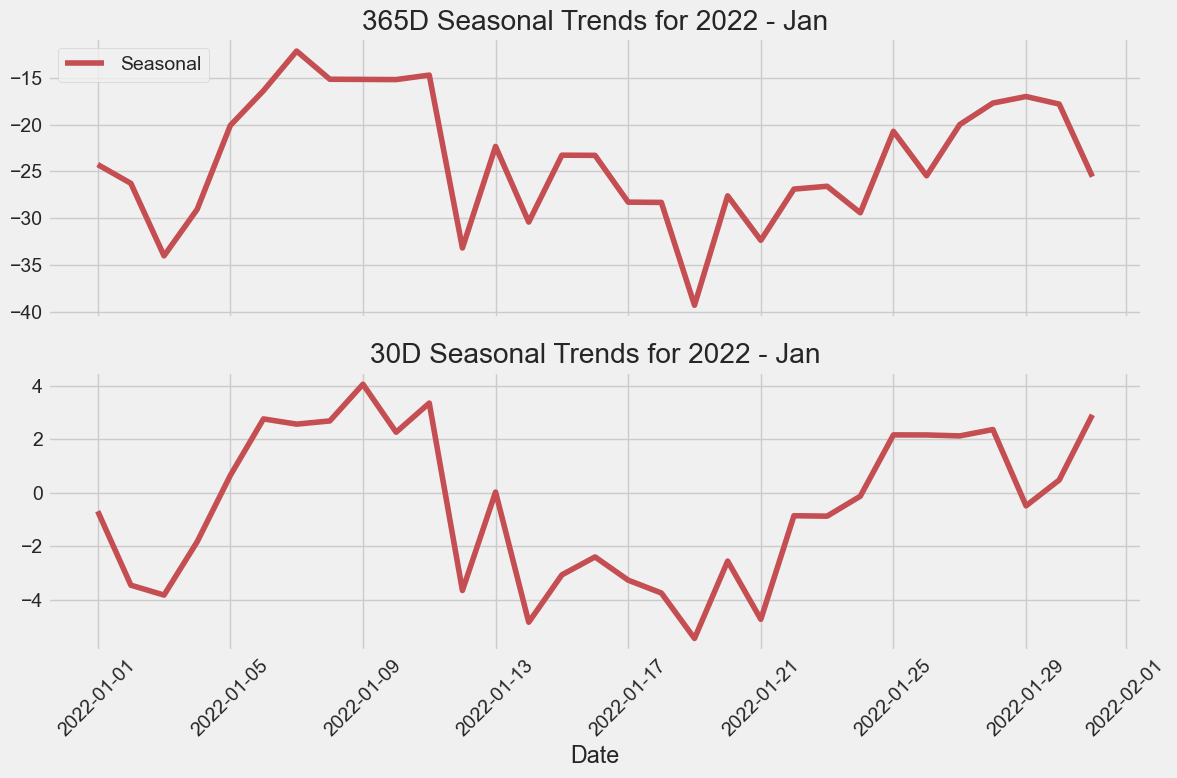

In [13]:
year = 2022
months_to_select = [1]

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]
selected_data2 = seasonal2[(seasonal2.index.year == year) & (seasonal2.index.month.isin(months_to_select))]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax1.plot(selected_data, label='Seasonal', color=deep_colors[2])
ax1.set_title(f'365D Seasonal Trends for {year} - Jan')
ax1.legend(loc='upper left')

ax2.plot(selected_data2, label='Seasonal', color=deep_colors[2])
ax2.set_title(f'30D Seasonal Trends for {year} - Jan')
ax2.set_xlabel('Date')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Assessing the amplitude or magnitude of the seasonal fluctuations**

In [14]:
# Assessing amplitude using statistical measures
seasonal_amplitude = seasonal.max() - seasonal.min()
std_dev = seasonal.std()
coefficient_of_variation = std_dev / seasonal.mean()
amplitude_mean = seasonal.mean()
amplitude_median = seasonal.median()
amplitude_variance = seasonal.var()
amplitude_percentile_95 = np.percentile(seasonal, 95)
amplitude_percentile_5 = np.percentile(seasonal, 5)

print("365D Seasonal Component")
print(f"Amplitude (Range) of Seasonal Component: {seasonal_amplitude:.2f}")
print(f"Mean of Seasonal Component: {amplitude_mean}")
print(f"Median of Seasonal Component: {amplitude_median:.2f}")
print(f"Variance of Seasonal Component: {amplitude_variance:.2f}")
print(f"Standard Deviation of Seasonal Component: {std_dev:.2f}")
print(f"Coefficient of Variation of Seasonal Component: {coefficient_of_variation:.4f}")
print(f"95th Percentile of Seasonal Component: {amplitude_percentile_95:.2f}")
print(f"5th Percentile of Seasonal Component: {amplitude_percentile_5:.2f}")

365D Seasonal Component
Amplitude (Range) of Seasonal Component: 226.94
Mean of Seasonal Component: -17.610597402618804
Median of Seasonal Component: -23.46
Variance of Seasonal Component: 2286.02
Standard Deviation of Seasonal Component: 47.81
Coefficient of Variation of Seasonal Component: -2.7150
95th Percentile of Seasonal Component: 83.28
5th Percentile of Seasonal Component: -74.78


In [15]:
seasonal_amplitude = seasonal2.max() - seasonal2.min()
std_dev = seasonal2.std()
coefficient_of_variation = std_dev / seasonal2.mean()
amplitude_mean = seasonal2.mean()
amplitude_median = seasonal2.median()
amplitude_variance = seasonal2.var()
amplitude_percentile_95 = np.percentile(seasonal2, 95)
amplitude_percentile_5 = np.percentile(seasonal2, 5)

print("30D Seasonal Component")
print(f"Amplitude (Range) of Seasonal Component: {seasonal_amplitude:.2f}")
print(f"Mean of Seasonal Component: {amplitude_mean}")
print(f"Median of Seasonal Component: {amplitude_median:.2f}")
print(f"Variance of Seasonal Component: {amplitude_variance:.2f}")
print(f"Standard Deviation of Seasonal Component: {std_dev:.2f}")
print(f"Coefficient of Variation of Seasonal Component: {coefficient_of_variation:.4f}")
print(f"95th Percentile of Seasonal Component: {amplitude_percentile_95:.2f}")
print(f"5th Percentile of Seasonal Component: {amplitude_percentile_5:.2f}")

30D Seasonal Component
Amplitude (Range) of Seasonal Component: 23.37
Mean of Seasonal Component: 0.04981231405032243
Median of Seasonal Component: -0.28
Variance of Seasonal Component: 14.75
Standard Deviation of Seasonal Component: 3.84
Coefficient of Variation of Seasonal Component: 77.0915
95th Percentile of Seasonal Component: 7.28
5th Percentile of Seasonal Component: -6.06


**Analyzing Residual Component**

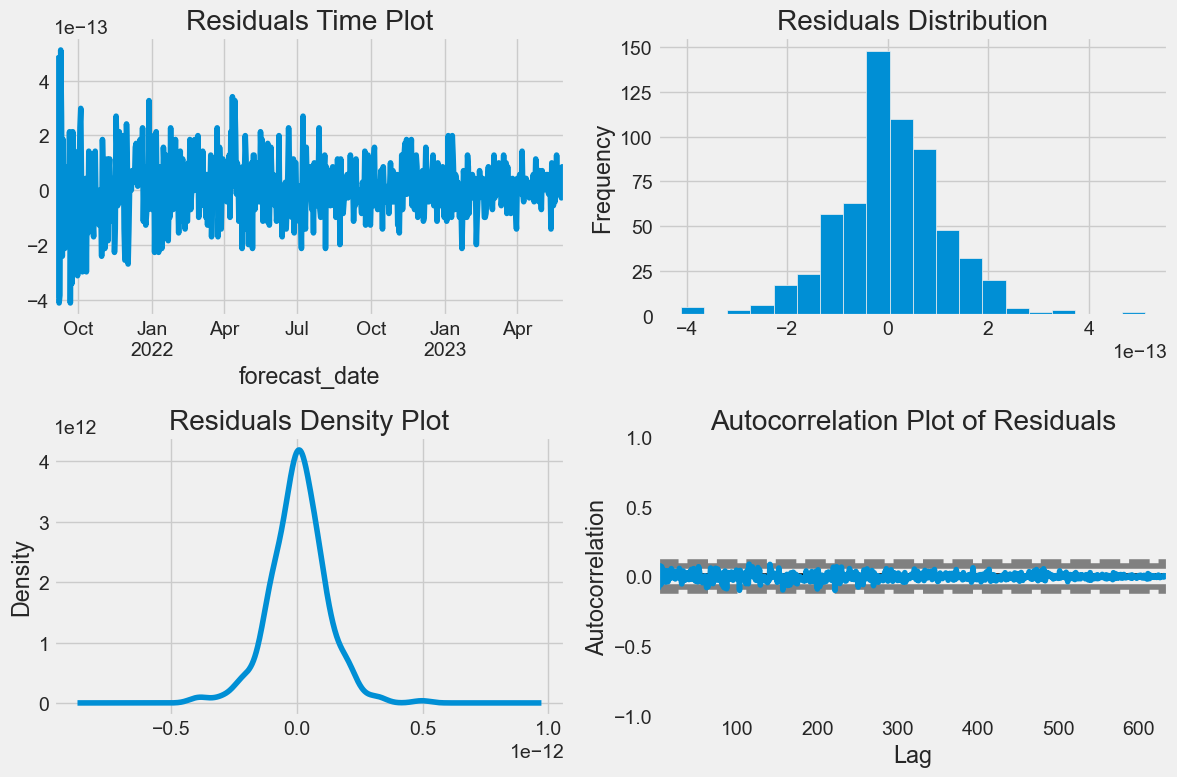

In [16]:
# 365D
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
residual.plot(title='Residuals Time Plot')

plt.subplot(2, 2, 2)
residual.plot(kind='hist', bins=20, title='Residuals Distribution')

plt.subplot(2, 2, 3)
residual.plot(kind='kde', title='Residuals Density Plot')

plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(residual)
plt.title('Autocorrelation Plot of Residuals')

plt.tight_layout()
plt.show()

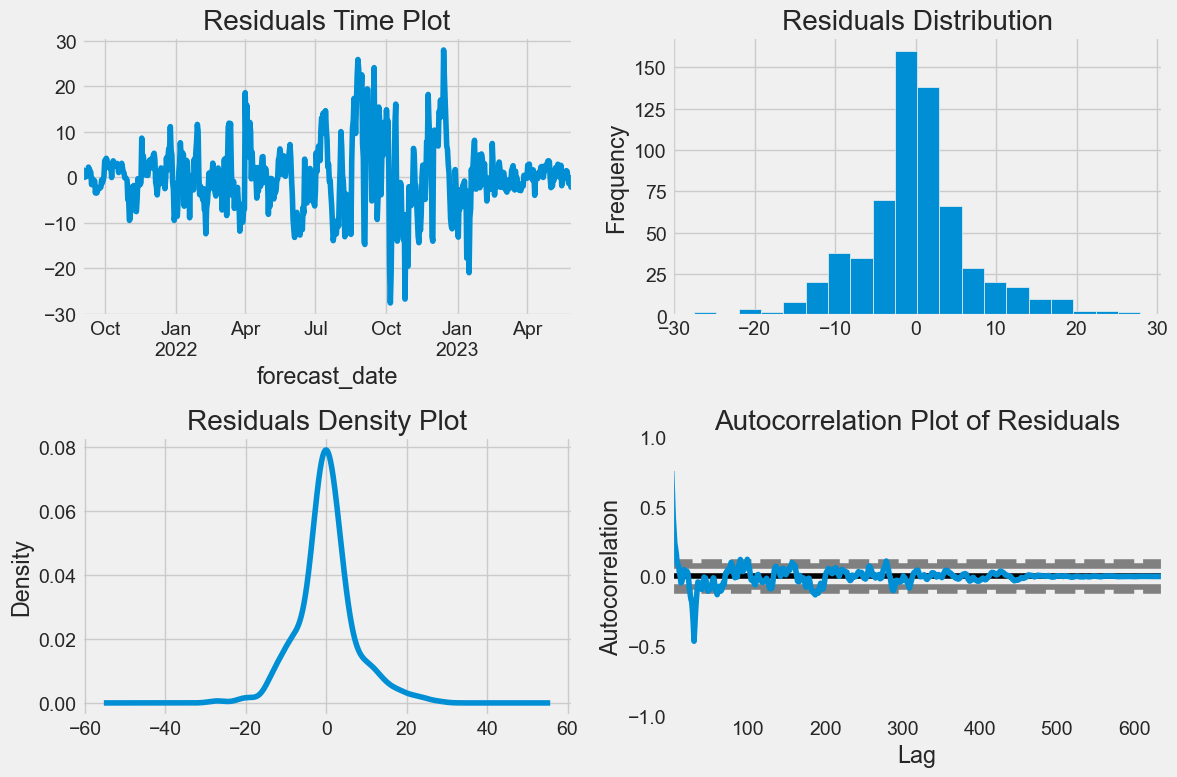

In [17]:
# 30D
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
residual2.plot(title='Residuals Time Plot')

plt.subplot(2, 2, 2)
residual2.plot(kind='hist', bins=20, title='Residuals Distribution')

plt.subplot(2, 2, 3)
residual2.plot(kind='kde', title='Residuals Density Plot')

plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(residual2)
plt.title('Autocorrelation Plot of Residuals')

plt.tight_layout()
plt.show()

Linear Regression Modeling of Time Index, Lags and Moving Averages

In [18]:
data = enefit_dict['gas_prices'].set_index('forecast_date').lowest_price_per_mwh.asfreq('D')
data = data.to_frame()
data['time'] = np.arange(len(data.index))
data['lag_1'] = data.lowest_price_per_mwh.shift(1)
data['lag_30'] = data.lowest_price_per_mwh.shift(30)
data['MA_30'] = data.lowest_price_per_mwh.rolling(window='30D', center=True, min_periods=20).mean()
data['MA_365'] = data.lowest_price_per_mwh.rolling(window='365D', center=True, min_periods=183).mean()

data.head()

lowest_price_per_mwh  time  lag_1  lag_30    MA_30     MA_365
forecast_date                                                               
2021-09-01                    45.23     0    NaN     NaN      NaN  73.174918
2021-09-02                    45.62     1  45.23     NaN      NaN  73.233750
2021-09-03                    45.85     2  45.62     NaN      NaN  73.313568
2021-09-04                    46.30     3  45.85     NaN      NaN  73.423387
2021-09-05                    46.30     4  46.30     NaN  46.5675  73.512032

In [19]:
formula = 'lowest_price_per_mwh ~ time'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     lowest_price_per_mwh   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                  0.000
Method:                   Least Squares   F-statistic:                     1.025
Date:                  Fri, 22 Dec 2023   Prob (F-statistic):              0.312
Time:                          05:27:59   Log-Likelihood:                -3362.8
No. Observations:                   637   AIC:                             6730.
Df Residuals:                       635   BIC:                             6739.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     98.3354      3.764

In [20]:
formula = 'lowest_price_per_mwh ~ lag_1'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     lowest_price_per_mwh   R-squared:                       0.982
Model:                              OLS   Adj. R-squared:                  0.982
Method:                   Least Squares   F-statistic:                 3.555e+04
Date:                  Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                          05:27:59   Log-Likelihood:                -2071.9
No. Observations:                   636   AIC:                             4148.
Df Residuals:                       634   BIC:                             4157.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7498      0.559

In [21]:
formula = 'lowest_price_per_mwh ~ lag_30'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     lowest_price_per_mwh   R-squared:                       0.563
Model:                              OLS   Adj. R-squared:                  0.562
Method:                   Least Squares   F-statistic:                     778.0
Date:                  Fri, 22 Dec 2023   Prob (F-statistic):          1.04e-110
Time:                          05:27:59   Log-Likelihood:                -2953.1
No. Observations:                   607   AIC:                             5910.
Df Residuals:                       605   BIC:                             5919.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9635      2.958

In [22]:
formula = 'lowest_price_per_mwh ~ MA_30'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     lowest_price_per_mwh   R-squared:                       0.971
Model:                              OLS   Adj. R-squared:                  0.971
Method:                   Least Squares   F-statistic:                 2.090e+04
Date:                  Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                          05:27:59   Log-Likelihood:                -2202.3
No. Observations:                   628   AIC:                             4409.
Df Residuals:                       626   BIC:                             4418.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8700      0.749

In [23]:
formula = 'lowest_price_per_mwh ~ MA_365'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     lowest_price_per_mwh   R-squared:                       0.543
Model:                              OLS   Adj. R-squared:                  0.542
Method:                   Least Squares   F-statistic:                     753.3
Date:                  Fri, 22 Dec 2023   Prob (F-statistic):          5.97e-110
Time:                          05:27:59   Log-Likelihood:                -3114.2
No. Observations:                   637   AIC:                             6232.
Df Residuals:                       635   BIC:                             6241.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -90.7272      6.887

For linear models, the best models use 1st lag or 30-day moving average to predict the target.

**Time Series Modeling**

In [24]:
df = enefit_dict['gas_prices'].set_index('forecast_date').lowest_price_per_mwh.asfreq('D')
ad_fuller_result = adfuller(df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.3611796336346396
p-value: 0.6007391995133301


In [25]:
df_diff = np.diff(df, n=1)
ad_fuller_result = adfuller(df_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -7.19679447875246
p-value: 2.4228558240429765e-10


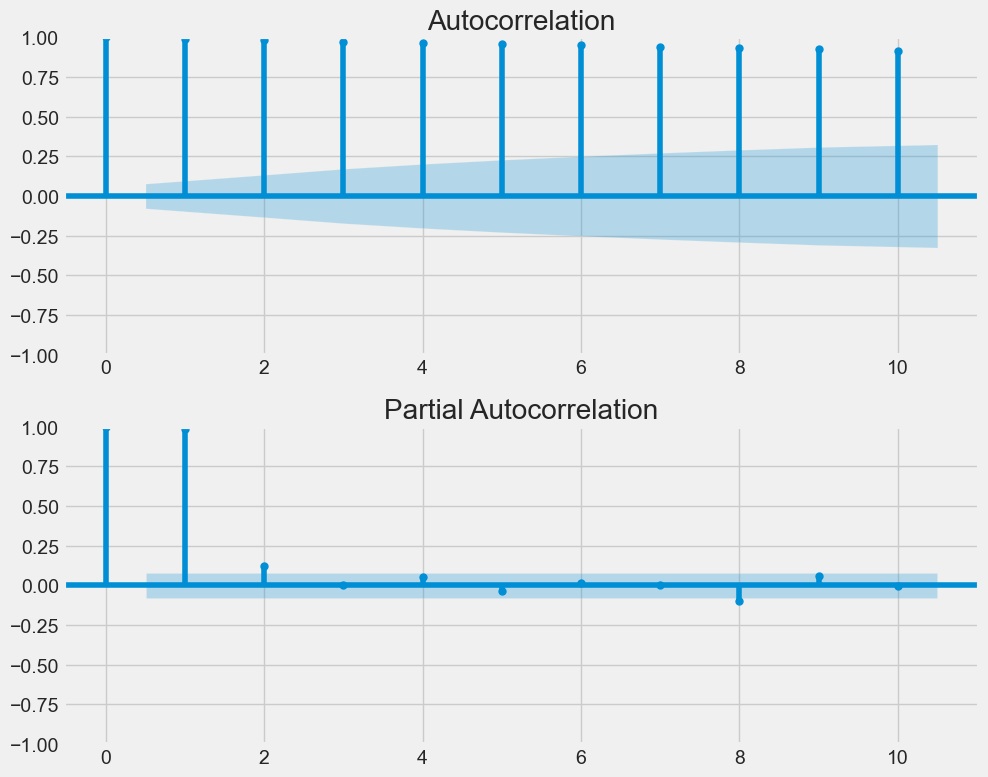

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df, lags=10, ax=ax1)
plot_pacf(df, lags=10, ax=ax2)
plt.tight_layout()
plt.show()

Lowest price per mwh can be modeled using ARIMA:

In [27]:
def optimize_ARIMA(
        # The order_list parameter now includes p, q orders. 
        endog: Union[pd.Series, list],
        # exog: Union[pd.Series, list], # useful for a SARIMAX model
        order_list: list,
        d: int,
        # D: int, s: int # useful for a SARIMAX model
) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        results = []

        # Loop over all unique ARIMA(p,d,q) models, 
        # fit them, and store the AICs.
        for order in notebook.tqdm(order_list):
            try:
                model = SARIMAX(
                    endog,
                    # exog,
                    order=(order[0], d, order[1]),
                    # seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue

            aic = model.aic
            results.append([order, aic])

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']

        #Sort in ascending order, lower AIC is better
        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        return result_df

In [28]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
d = 1

ARIMA_order_list = list(product(ps, qs))
ARIMA_result_df = optimize_ARIMA(df, ARIMA_order_list, d)
ARIMA_result_df.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(p,q)          AIC
0  (2, 3)  4125.067640
1  (3, 2)  4126.126408
2  (2, 4)  4127.041114
3  (3, 3)  4127.055584
4  (4, 2)  4127.199923

In [29]:
df = enefit_dict['gas_prices'].set_index('forecast_date').lowest_price_per_mwh.asfreq('D')
d = 1

SARIMAX_model = SARIMAX(
    endog=df,
    order=(ARIMA_result_df.iloc[0,0][0], d, ARIMA_result_df.iloc[0,0][1]),
    simple_differencing=False
)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)
print(SARIMAX_model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     lowest_price_per_mwh   No. Observations:                  637
Model:                 SARIMAX(2, 1, 3)   Log Likelihood               -2056.534
Date:                  Fri, 22 Dec 2023   AIC                           4125.068
Time:                          05:28:08   BIC                           4151.799
Sample:                      09-01-2021   HQIC                          4135.446
                           - 05-30-2023                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2568      0.057    -22.049      0.000      -1.368      -1.145
ar.L2         -0.8163      0.058    -14.025      0.000      -0.930      -0.702
ma.L1          1.1064      0.061    

Residual analysis:

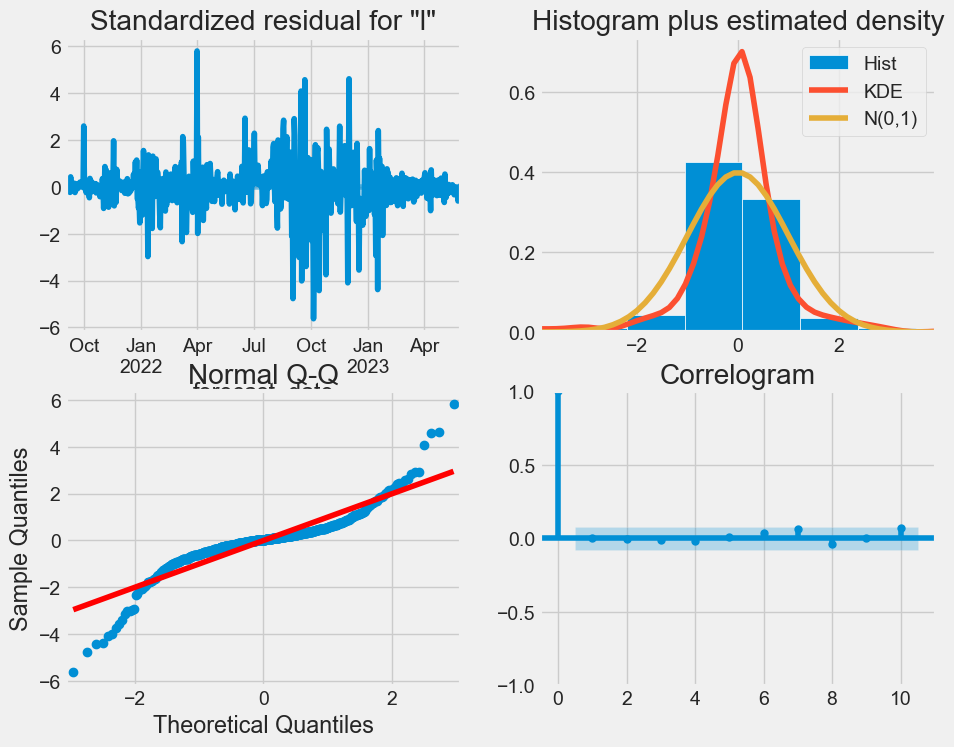

In [30]:
SARIMAX_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [31]:
residuals = SARIMAX_model_fit.resid
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_df

lb_stat  lb_pvalue
1   0.001458   0.969546
2   0.003770   0.998117
3   0.036927   0.998134
4   0.187686   0.995863
5   0.234961   0.998691
6   0.992339   0.985901
7   3.049912   0.880347
8   4.053302   0.852283
9   4.109633   0.904050
10  6.708961   0.752605

**Historical Weather**

The features in this dataset are:
* datetime: This represents the start of the 1-hour period for which weather data are measured.
* temperature: Measured at the end of the 1-hour period.
* dewpoint: Measured at the end of the 1-hour period.
* rain: Different from the forecast conventions. The rain from large scale weather systems of the hour in millimeters.
* snowfall: Different from the forecast conventions. Snowfall over the hour in centimeters.
* surface_pressure: The air pressure at surface in hectopascals.
* cloudcover_[low/mid/high/total]: Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
* windspeed_10m: Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
* winddirection_10m: Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
* shortwave_radiation: Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
* direct_solar_radiation: The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
* diffuse_radiation: Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
* latitude/longitude: The coordinates of the weather station.
* data_block_id:  All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.

In [32]:
enefit_dict['historical_weather'].head()

datetime  temperature  dewpoint  rain  snowfall  surface_pressure  \
0 2021-09-01         14.4      12.0   0.0       0.0            1015.8   
1 2021-09-01         14.0      12.0   0.0       0.0            1010.6   
2 2021-09-01         14.4      12.8   0.0       0.0            1014.9   
3 2021-09-01         15.4      13.0   0.0       0.0            1014.4   
4 2021-09-01         15.9      12.6   0.0       0.0            1013.8   

   cloudcover_total  cloudcover_low  cloudcover_mid  cloudcover_high  \
0                 4               4               0                0   
1                 7               8               0                0   
2                 6               7               0                0   
3                 4               2               4                0   
4                12               7               0               20   

   windspeed_10m  winddirection_10m  shortwave_radiation  \
0       6.694444                  3                  0.0   
1       4.944444                353                  0.0   
2       5.833333                348                  0.0   
3       7.111111                349                  0.0   
4       8.388889                360                  0.0   

   direct_solar_radiation  diffuse_radiation  latitude  longitude  \
0                     0.0                0.0      57.6       21.7   
1                     0.0                0.0      57.6       22.2   
2                     0.0                0.0      57.6       22.7   
3                     0.0                0.0      57.6       23.2   
4                     0.0                0.0      57.6       23.7   

   data_block_id  
0              1  
1              1  
2              1  
3              1  
4              1

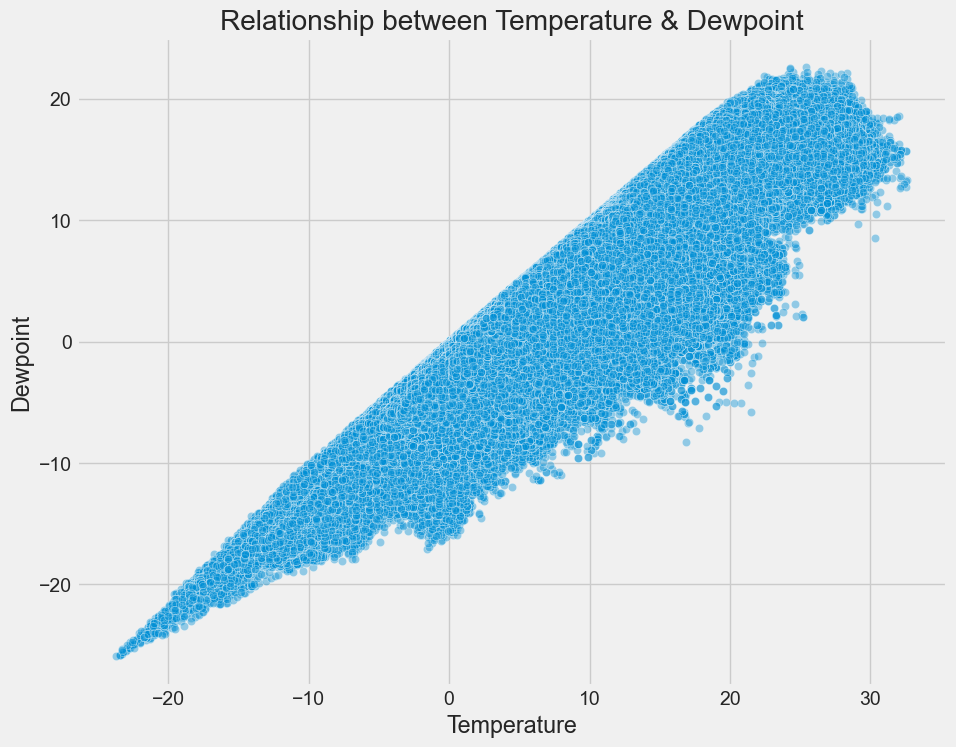

In [33]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=enefit_dict['historical_weather'],
    x='temperature', y='dewpoint', alpha=.4
)
plt.xlabel('Temperature')
plt.ylabel('Dewpoint')
plt.title('Relationship between Temperature & Dewpoint')
plt.show()

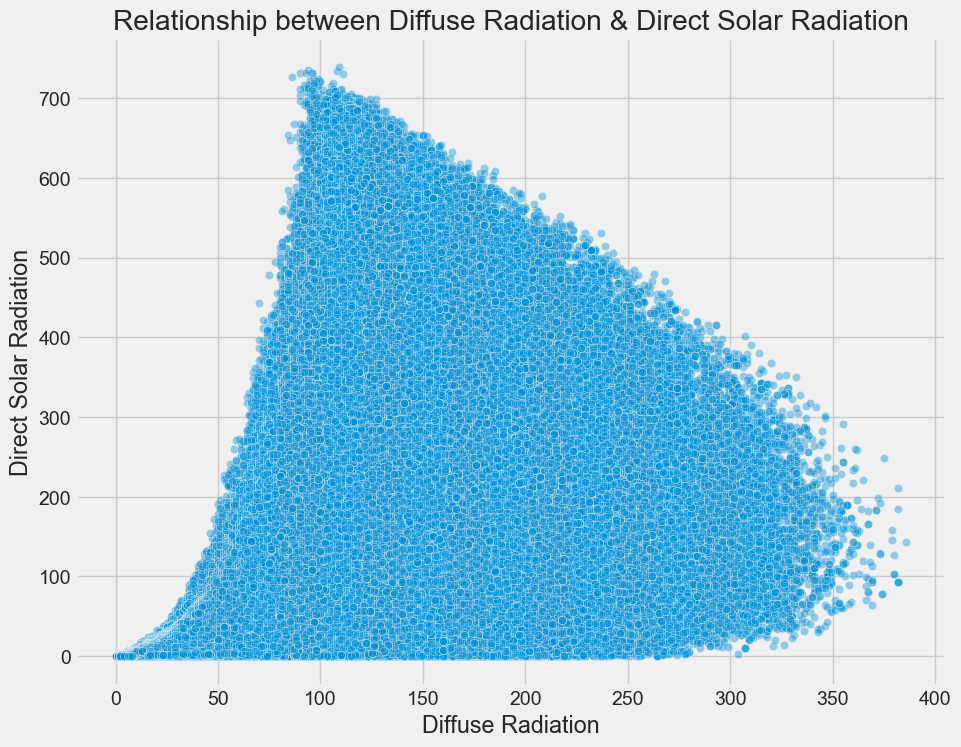

In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=enefit_dict['historical_weather'],
    x='diffuse_radiation',
    y='direct_solar_radiation', alpha=.4
)
plt.xlabel('Diffuse Radiation')
plt.ylabel('Direct Solar Radiation')
plt.title('Relationship between Diffuse Radiation & Direct Solar Radiation')
plt.show()

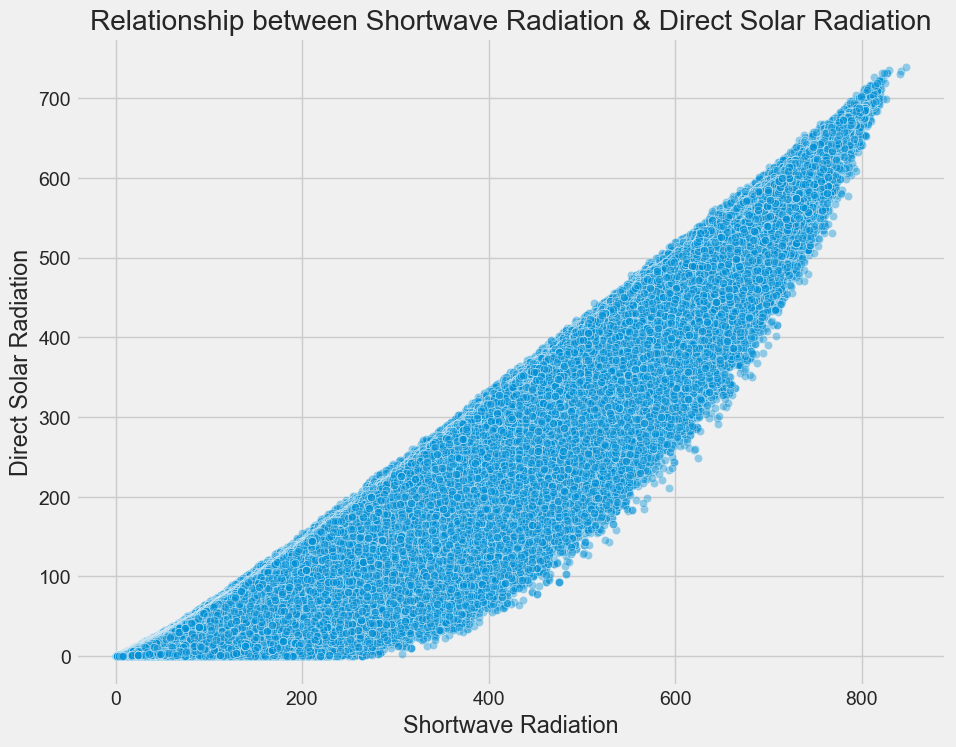

In [35]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=enefit_dict['historical_weather'],
    x='shortwave_radiation',
    y='direct_solar_radiation', alpha=.4
)
plt.xlabel('Shortwave Radiation')
plt.ylabel('Direct Solar Radiation')
plt.title('Relationship between Shortwave Radiation & Direct Solar Radiation')
plt.show()

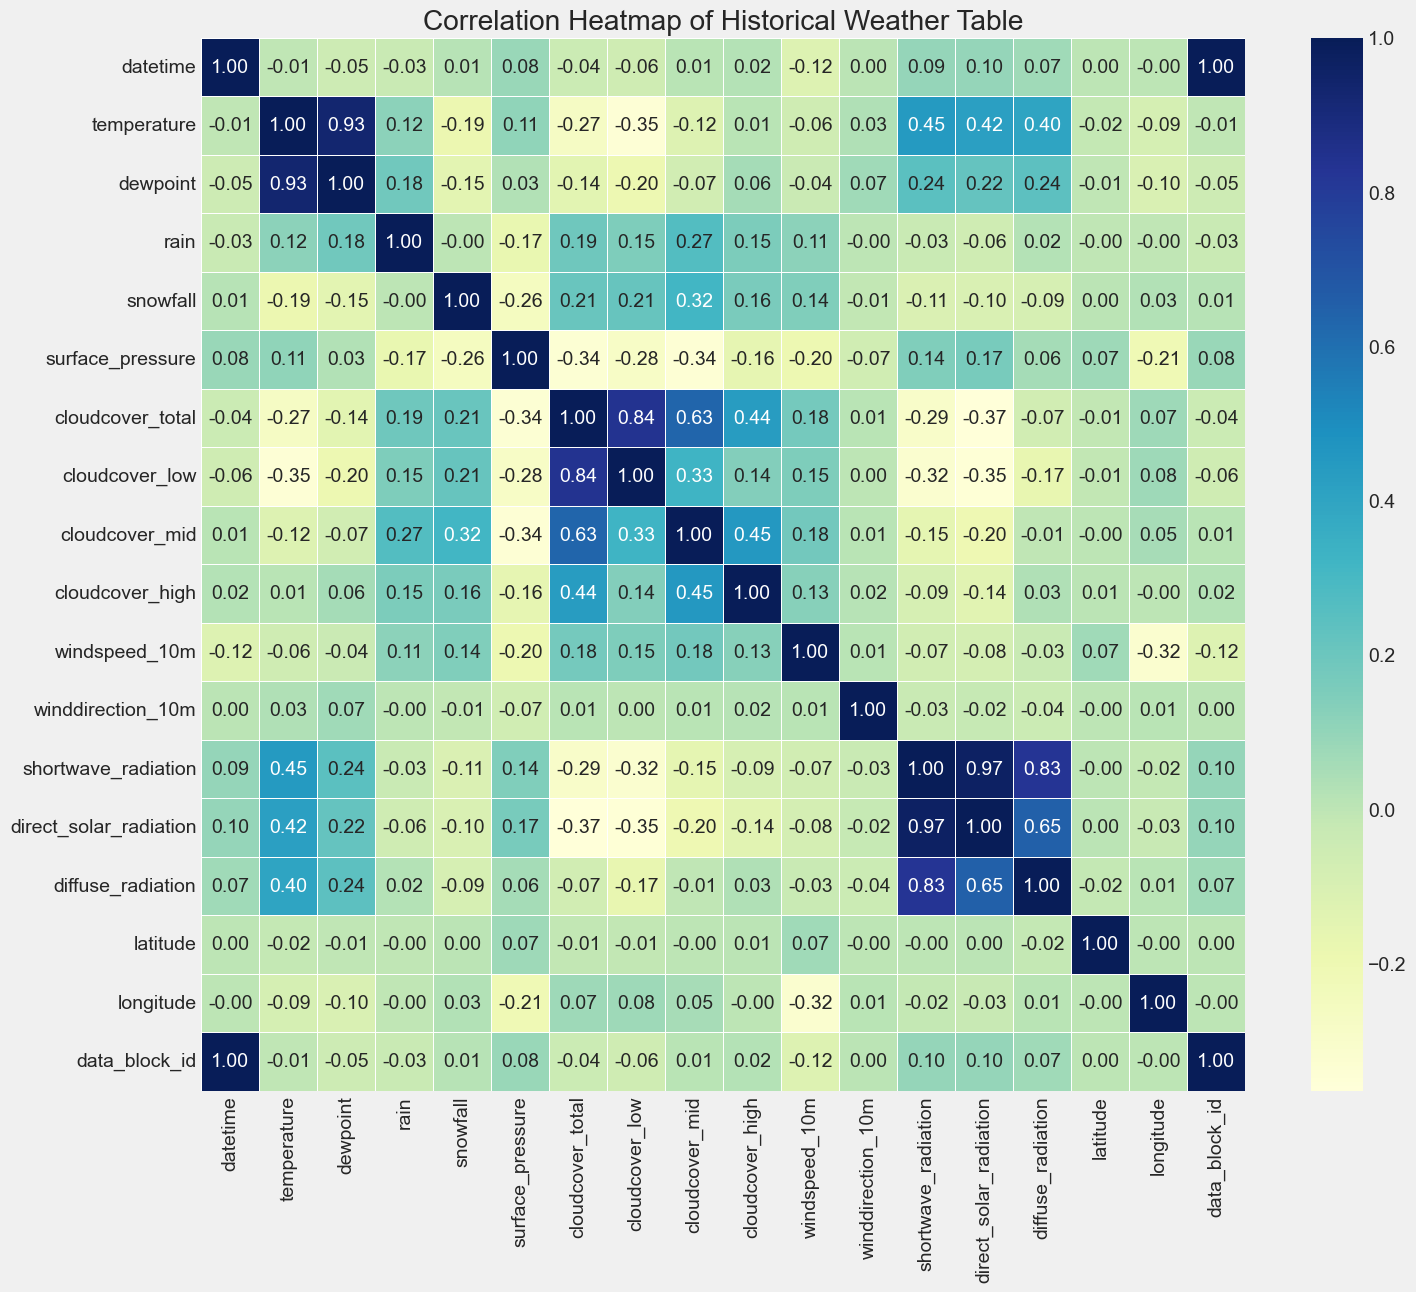

In [36]:
plt.figure(figsize=(15, 13))
sns.heatmap(
    enefit_dict['historical_weather'].corr(),
    annot=True,
    linewidths=0.5,
    fmt= ".2f",
    cmap="YlGnBu"
)
plt.title('Correlation Heatmap of Historical Weather Table')
plt.show()

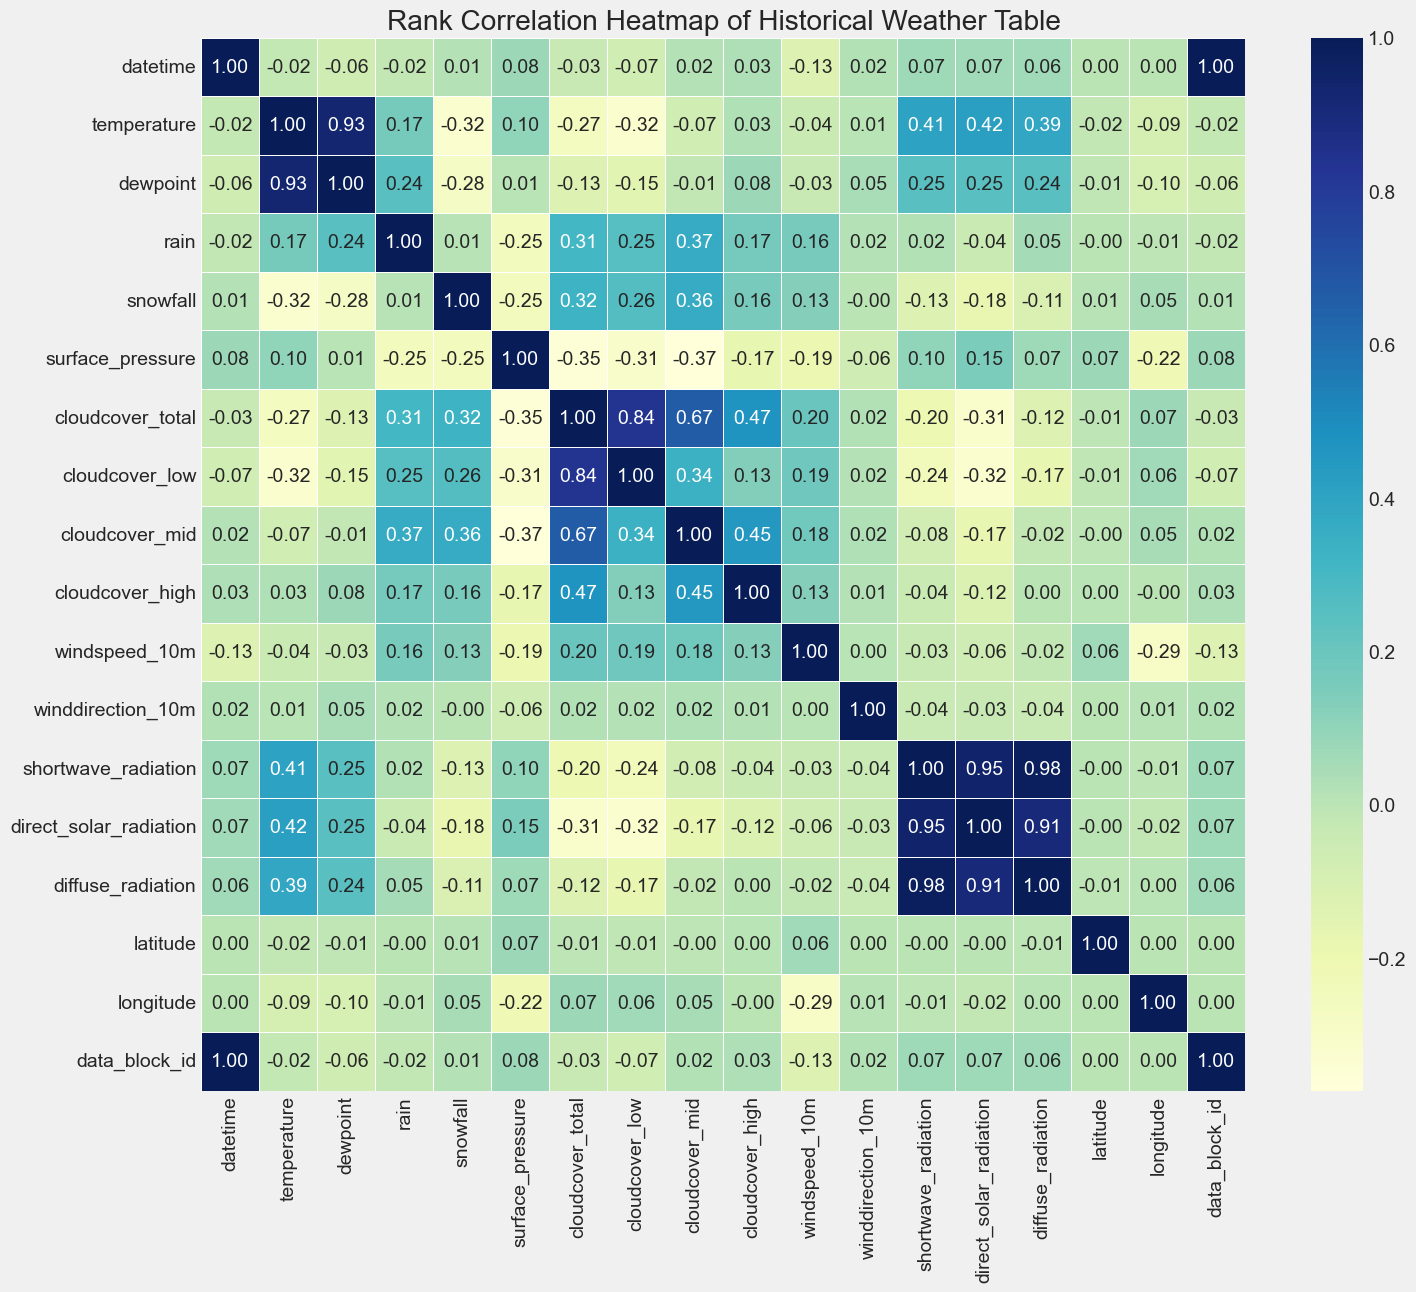

In [37]:
plt.figure(figsize=(15, 13))
sns.heatmap(
    enefit_dict['historical_weather'].corr(method='spearman'),
    annot=True,
    linewidths=0.5,
    fmt= ".2f",
    cmap="YlGnBu"
)
plt.title('Rank Correlation Heatmap of Historical Weather Table')
plt.show()

Explaining Variations in Solar Radiation:

In [38]:
data = enefit_dict['historical_weather']

formula = 'direct_solar_radiation ~ longitude + latitude + temperature + dewpoint + cloudcover_total + snowfall + rain + surface_pressure + windspeed_10m + winddirection_10m'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     direct_solar_radiation   R-squared:                       0.421
Model:                                OLS   Adj. R-squared:                  0.421
Method:                     Least Squares   F-statistic:                 1.246e+05
Date:                    Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                            05:28:39   Log-Likelihood:            -1.0325e+07
No. Observations:                 1710800   AIC:                         2.065e+07
Df Residuals:                     1710789   BIC:                         2.065e+07
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

Seasonality in Solar Radiation

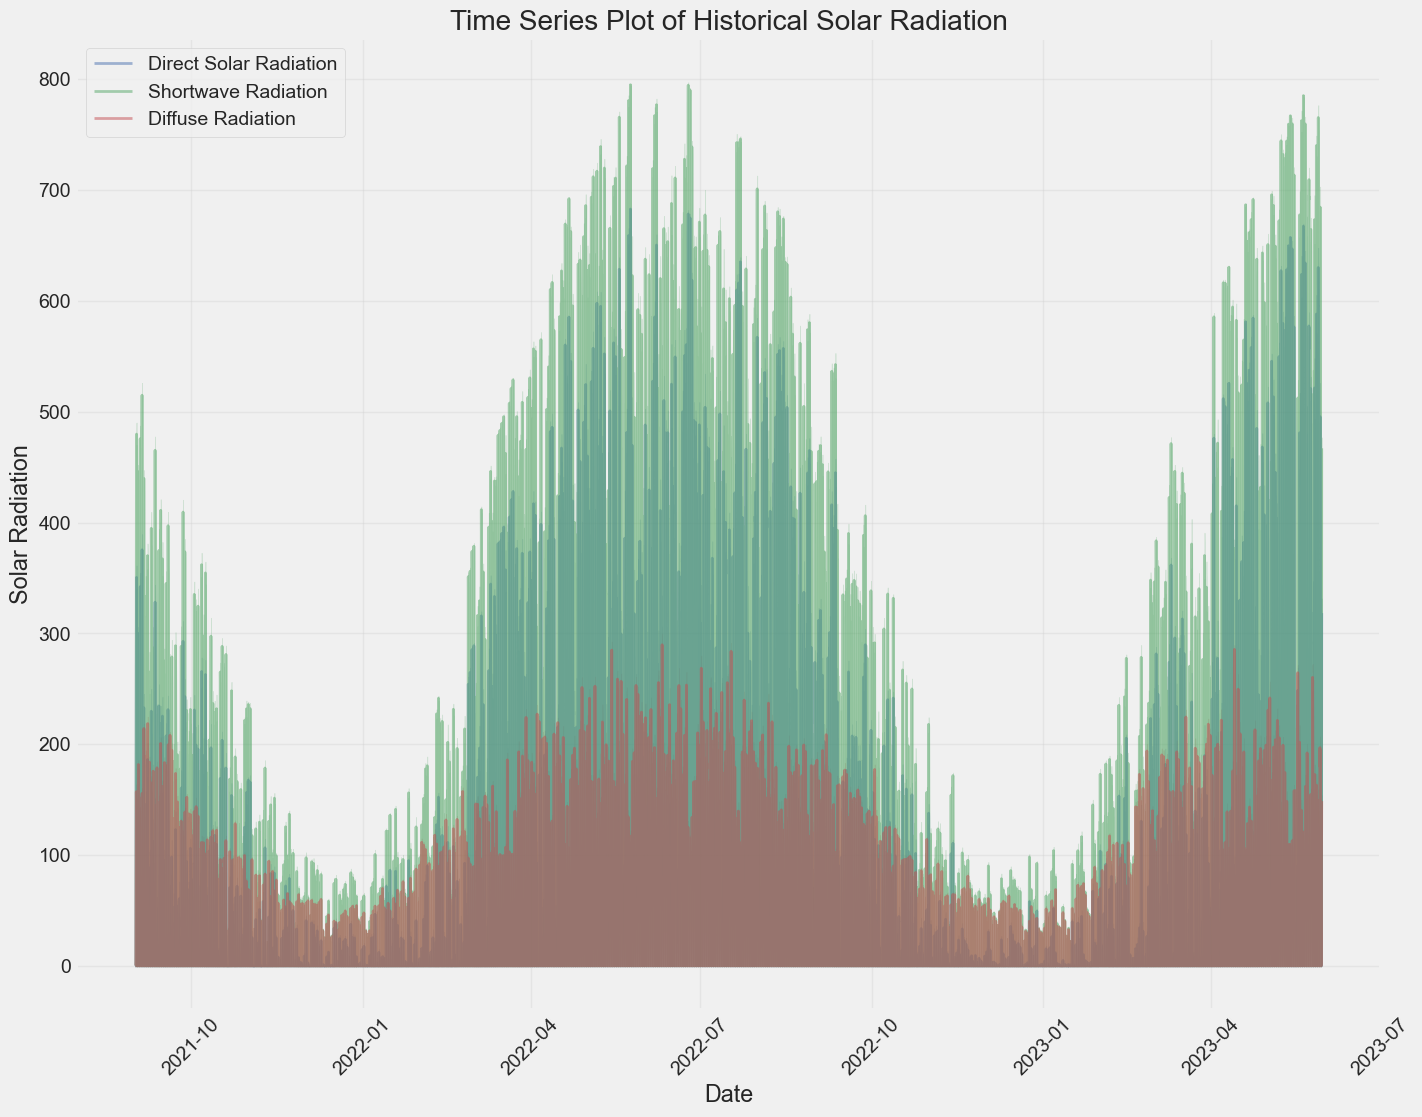

In [39]:
plt.figure(figsize=(15, 12))
sns.lineplot(
    x='datetime', y='direct_solar_radiation',
    data=enefit_dict['historical_weather'],
    estimator='mean', size=.7, label='Direct Solar Radiation',
    legend='brief', alpha=.5, color=deep_colors[0]
)
sns.lineplot(
    x='datetime', y='shortwave_radiation',
    data=enefit_dict['historical_weather'],
    estimator='mean', size=.7, label='Shortwave Radiation',
    legend='brief', alpha=.5, color=deep_colors[1]
)
sns.lineplot(
    x='datetime', y='diffuse_radiation',
    data=enefit_dict['historical_weather'],
    estimator='mean', size=.7, label='Diffuse Radiation',
    legend='brief', alpha=.5, color=deep_colors[2]
)

plt.xlabel('Date')
plt.ylabel('Solar Radiation')
plt.title('Time Series Plot of Historical Solar Radiation')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend()

plt.show()

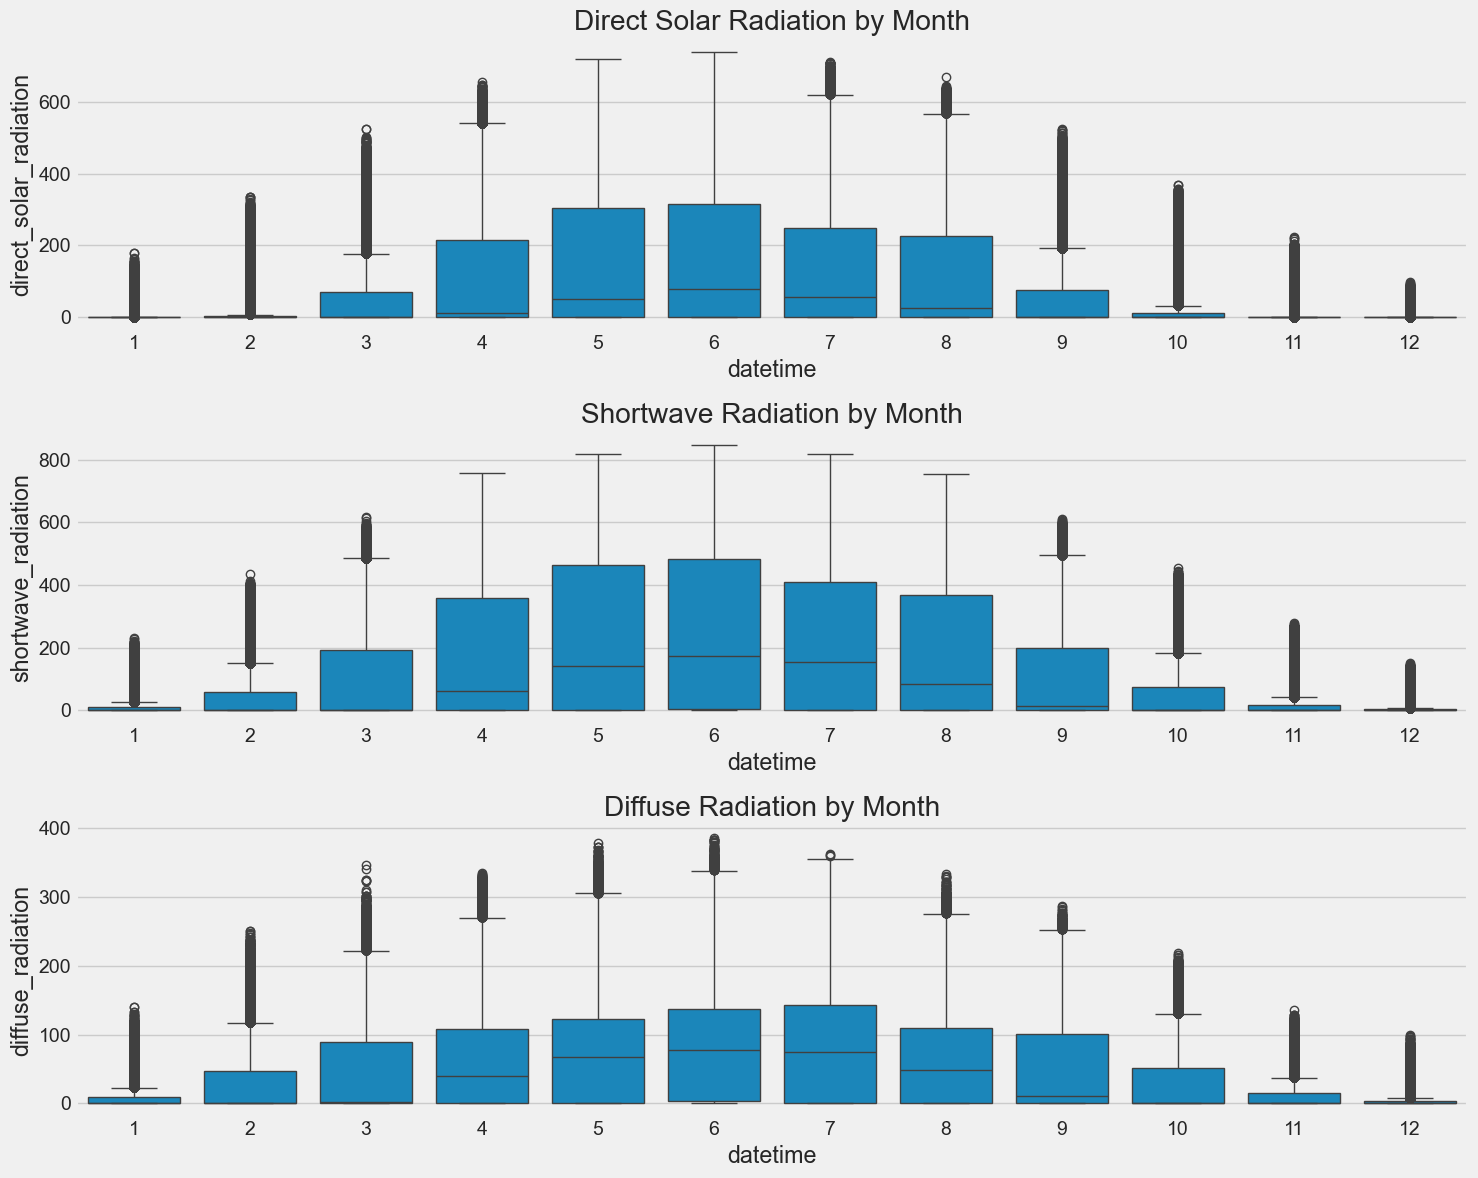

In the peak (summer) months, surface solar radiation downwards is not as high as direct solar radiation, but in the winter months, it is significanly higher.


In [40]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
sns.boxplot(
    x=enefit_dict['historical_weather'].datetime.dt.month,
    y='direct_solar_radiation',
    data=enefit_dict['historical_weather']
)
plt.title('Direct Solar Radiation by Month')

plt.subplot(312)
sns.boxplot(
    x=enefit_dict['historical_weather'].datetime.dt.month,
    y='shortwave_radiation',
    data=enefit_dict['historical_weather']
)
plt.title('Shortwave Radiation by Month')

plt.subplot(313)
sns.boxplot(
    x=enefit_dict['historical_weather'].datetime.dt.month,
    y='diffuse_radiation',
    data=enefit_dict['historical_weather']
)
plt.title('Diffuse Radiation by Month')

plt.tight_layout()
plt.show()

print('In the peak (summer) months, surface solar radiation downwards is not as high as direct solar radiation, but in the winter months, it is significanly higher.')

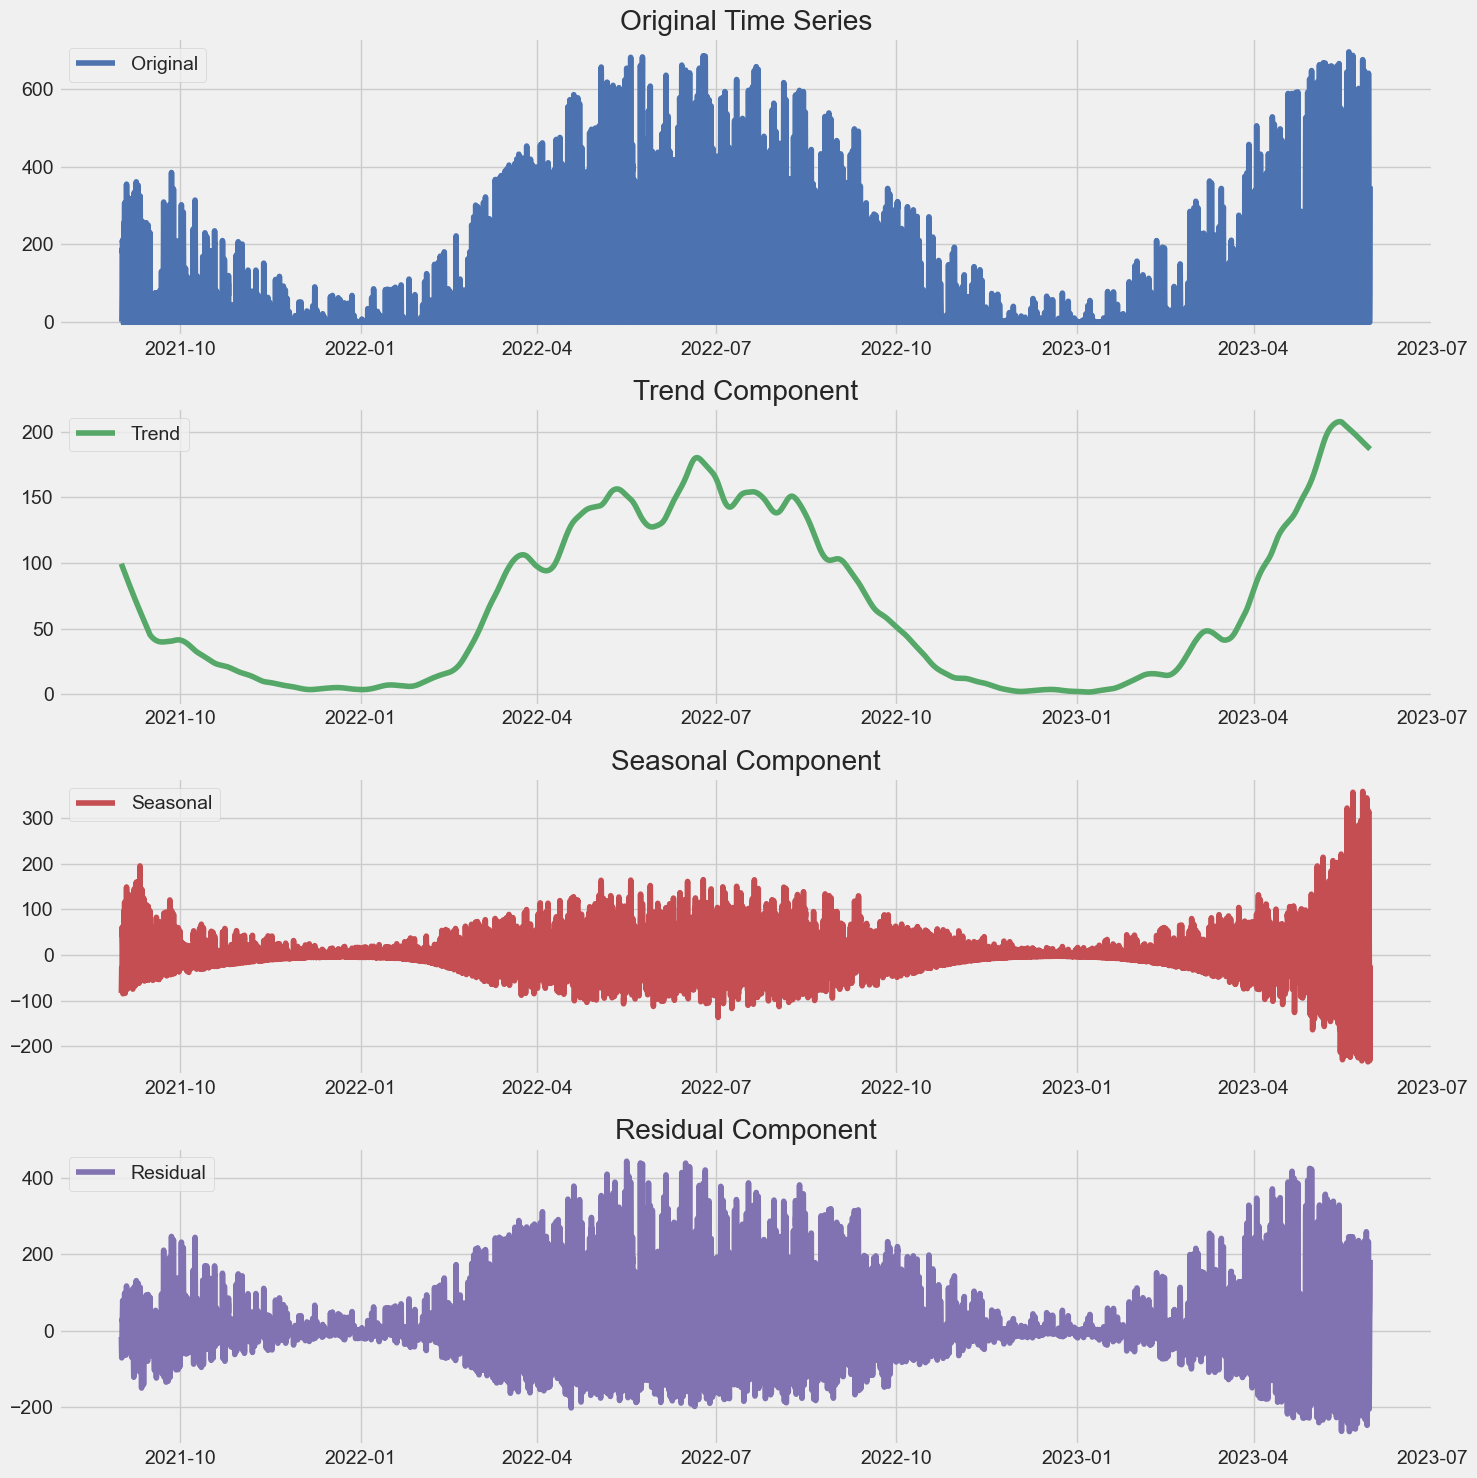

In [41]:
data = enefit_dict['historical_weather'].set_index('datetime').direct_solar_radiation
duplicates = data.index.duplicated()
data = data[~duplicates].copy()
# data = data.asfreq('D').bfill()

decomposition = STL(data, period=365).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original time series
plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(decomposition.observed, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

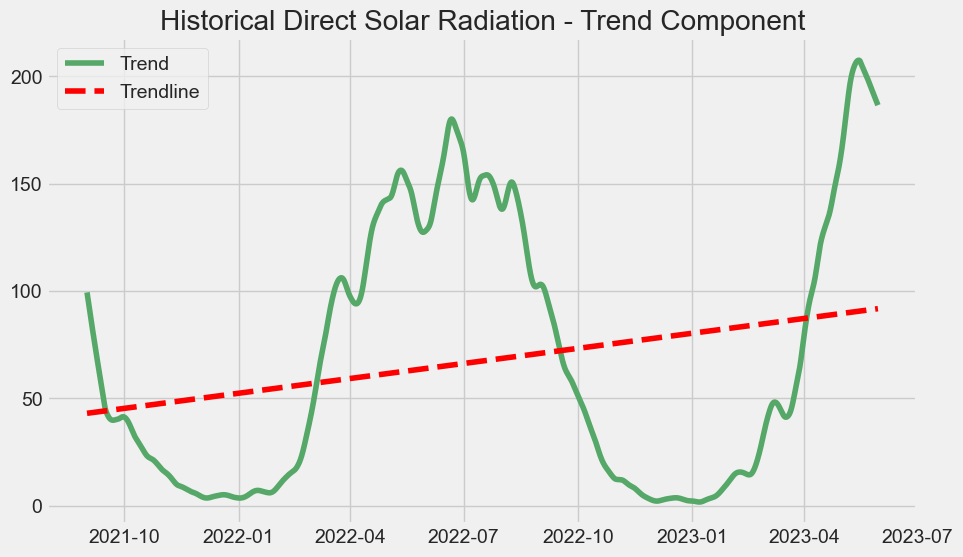

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend', color=deep_colors[1])

# Fit a linear regression trend-line
x_values = pd.to_numeric(trend.index) / 10**9
coefficients = np.polyfit(x_values, trend.fillna(0), 1)
slope, intercept = coefficients
trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)

plt.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')
plt.legend(loc='upper left')
plt.title('Historical Direct Solar Radiation - Trend Component')

plt.show()

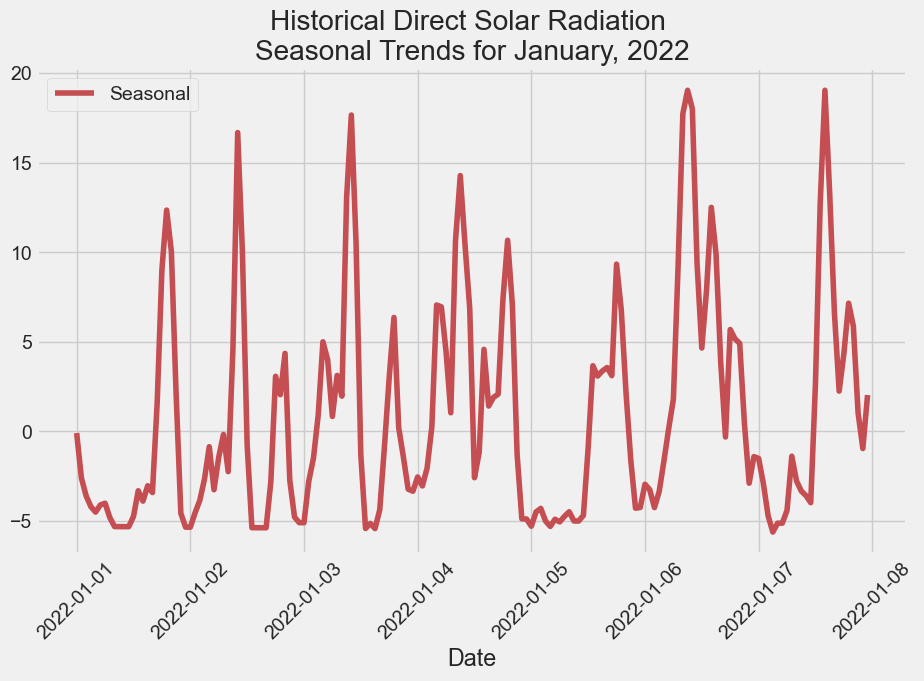

In [43]:
year = 2022
months_to_select = [1]
days_to_select = range(1, 8)

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select)) & (seasonal.index.day.isin(days_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal', color=deep_colors[2])
plt.xlabel('Date')
plt.title(f'Historical Direct Solar Radiation \nSeasonal Trends for January, {year}')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [44]:
seasonal_amplitude = seasonal.max() - seasonal.min()
std_dev = seasonal.std()
coefficient_of_variation = std_dev / seasonal.mean()
amplitude_mean = seasonal.mean()
amplitude_median = seasonal.median()
amplitude_variance = seasonal.var()
amplitude_percentile_95 = np.percentile(seasonal, 95)
amplitude_percentile_5 = np.percentile(seasonal, 5)

print('Direct Solar Radiation:')
print(f"Amplitude (Range) of Seasonal Component: {seasonal_amplitude:.2f}")
print(f"Mean of Seasonal Component: {amplitude_mean}")
print(f"Median of Seasonal Component: {amplitude_median:.2f}")
print(f"Variance of Seasonal Component: {amplitude_variance:.2f}")
print(f"Standard Deviation of Seasonal Component: {std_dev:.2f}")
print(f"Coefficient of Variation of Seasonal Component: {coefficient_of_variation:.4f}")
print(f"95th Percentile of Seasonal Component: {amplitude_percentile_95:.2f}")
print(f"5th Percentile of Seasonal Component: {amplitude_percentile_5:.2f}")

Direct Solar Radiation:
Amplitude (Range) of Seasonal Component: 593.19
Mean of Seasonal Component: 0.07211395550741441
Median of Seasonal Component: -3.15
Variance of Seasonal Component: 2418.81
Standard Deviation of Seasonal Component: 49.18
Coefficient of Variation of Seasonal Component: 681.9963
95th Percentile of Seasonal Component: 83.35
5th Percentile of Seasonal Component: -70.43


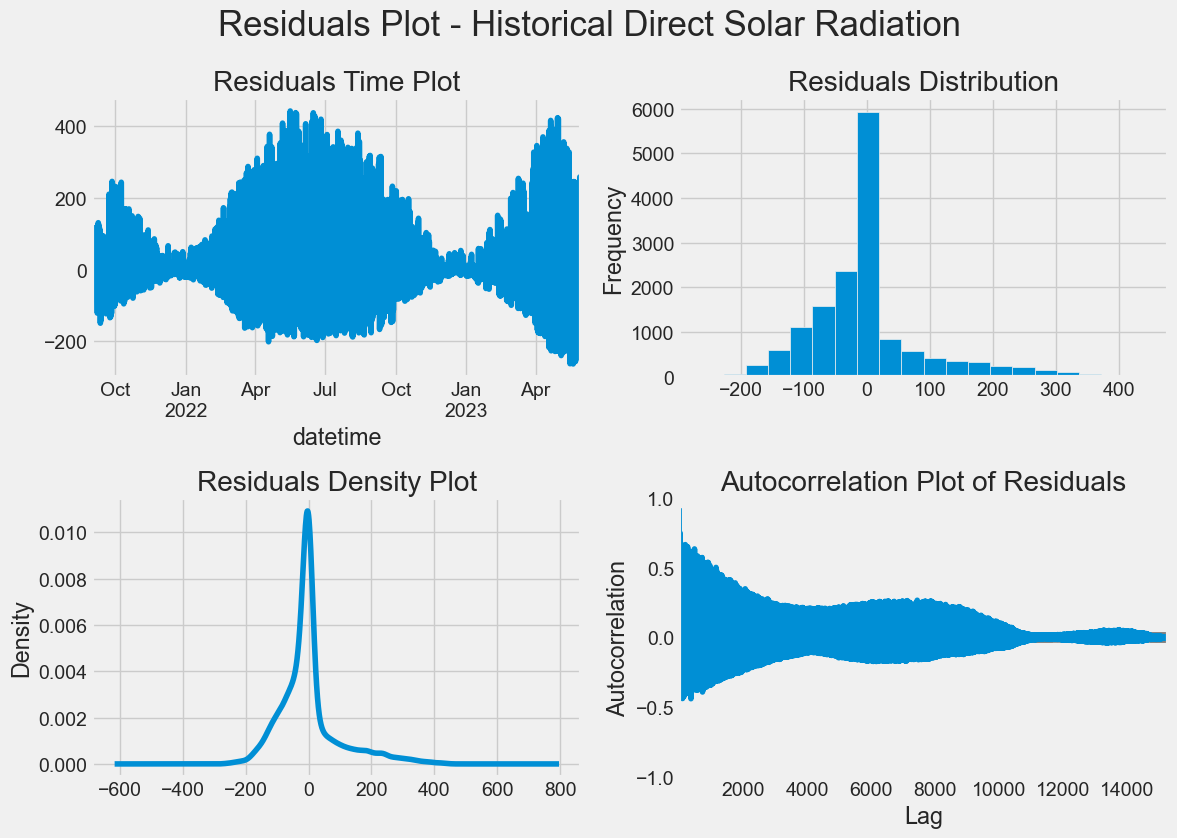

In [45]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
residual.plot(title='Residuals Time Plot')

plt.subplot(2, 2, 2)
residual.plot(kind='hist', bins=20, title='Residuals Distribution')

plt.subplot(2, 2, 3)
residual.plot(kind='kde', title='Residuals Density Plot')

plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(residual)
plt.title('Autocorrelation Plot of Residuals')

plt.tight_layout()
plt.suptitle('Residuals Plot - Historical Direct Solar Radiation', y=1.05, fontsize=25)
plt.show()

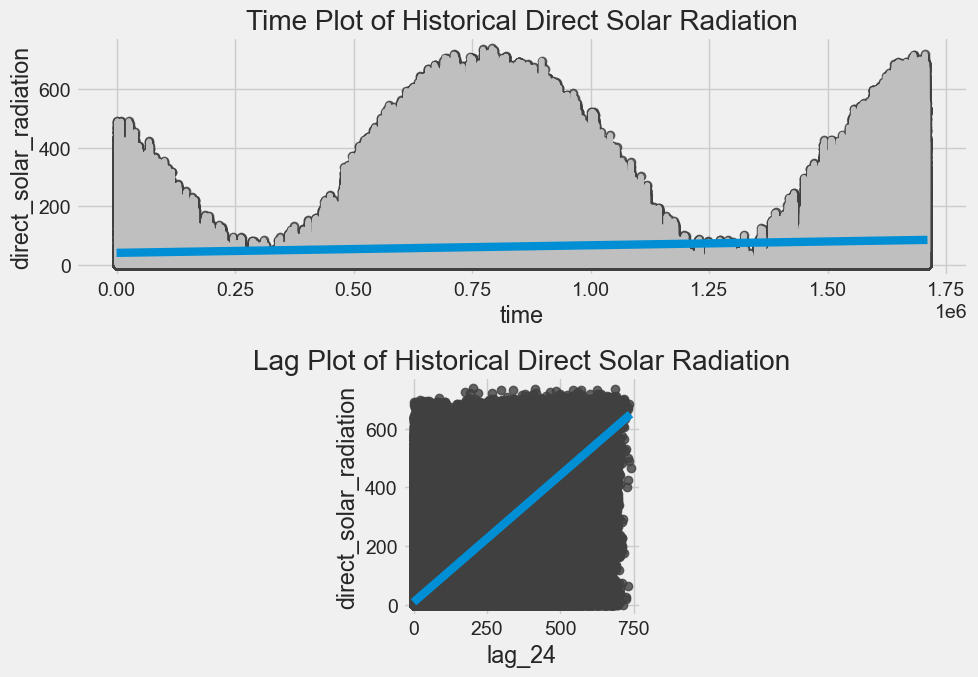

In [46]:
data = enefit_dict['historical_weather'].set_index('datetime').direct_solar_radiation#.resample('D').mean()
data = data.to_frame()
data['time'] = np.arange(len(data.index))
data['lag_1'] = data.direct_solar_radiation.shift(1)
data['lag_24'] = data.direct_solar_radiation.shift(24)
data['lag_30'] = data.direct_solar_radiation.shift(30)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
ax1.plot('time', 'direct_solar_radiation', data=data, color='0.75')
sns.regplot(
    x='time', y='direct_solar_radiation', data=data,
    ci=None, scatter_kws=dict(color='.25'), ax=ax1
)
ax1.set_title('Time Plot of Historical Direct Solar Radiation')

sns.regplot(
    x='lag_24', y='direct_solar_radiation', data=data,
    ci=None, scatter_kws=dict(color='0.25'), ax=ax2
)
ax2.set_aspect('equal')
ax2.set_title('Lag Plot of Historical Direct Solar Radiation')

plt.tight_layout()
plt.show()

In [47]:
formula = 'direct_solar_radiation ~ time'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     direct_solar_radiation   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.009
Method:                     Least Squares   F-statistic:                 1.590e+04
Date:                    Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                            05:39:40   Log-Likelihood:            -1.0785e+07
No. Observations:                 1710800   AIC:                         2.157e+07
Df Residuals:                     1710798   BIC:                         2.157e+07
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [48]:
formula = 'direct_solar_radiation ~ lag_1'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     direct_solar_radiation   R-squared:                       0.944
Model:                                OLS   Adj. R-squared:                  0.944
Method:                     Least Squares   F-statistic:                 2.862e+07
Date:                    Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                            05:39:41   Log-Likelihood:            -8.3331e+06
No. Observations:                 1710799   AIC:                         1.667e+07
Df Residuals:                     1710797   BIC:                         1.667e+07
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [49]:
formula = 'direct_solar_radiation ~ lag_24'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     direct_solar_radiation   R-squared:                       0.751
Model:                                OLS   Adj. R-squared:                  0.751
Method:                     Least Squares   F-statistic:                 5.164e+06
Date:                    Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                            05:39:41   Log-Likelihood:            -9.6028e+06
No. Observations:                 1710776   AIC:                         1.921e+07
Df Residuals:                     1710774   BIC:                         1.921e+07
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [50]:
formula = 'direct_solar_radiation ~ lag_30'
model = smf.ols(formula, data=data)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     direct_solar_radiation   R-squared:                       0.813
Model:                                OLS   Adj. R-squared:                  0.813
Method:                     Least Squares   F-statistic:                 7.460e+06
Date:                    Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                            05:39:41   Log-Likelihood:            -9.3563e+06
No. Observations:                 1710770   AIC:                         1.871e+07
Df Residuals:                     1710768   BIC:                         1.871e+07
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [51]:
enefit_dict['historical_weather'].columns

Index(['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall',
       'surface_pressure', 'cloudcover_total', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'latitude', 'longitude', 'data_block_id'],
      dtype='object')

In [52]:
exog_cols = ['temperature', 'dewpoint', 'cloudcover_total', 'snowfall', 'rain', 'surface_pressure', 'windspeed_10m', 'winddirection_10m']
data = enefit_dict['historical_weather'].set_index('datetime')[exog_cols + ['direct_solar_radiation']].resample('D').mean()
target = data.direct_solar_radiation
exog = data[exog_cols]

data.head()

temperature  dewpoint  cloudcover_total  snowfall      rain  \
datetime                                                                  
2021-09-01    13.500595  8.907813         39.103423       0.0  0.012277   
2021-09-02    12.042746  6.517485         53.175223       0.0  0.040737   
2021-09-03    11.919829  6.719717         52.005208       0.0  0.098289   
2021-09-04    10.239844  5.174033         32.226562       0.0  0.080394   
2021-09-05     9.689583  3.222582         62.308780       0.0  0.002530   

            surface_pressure  windspeed_10m  winddirection_10m  \
datetime                                                         
2021-09-01       1008.257552       6.403925         326.902530   
2021-09-02       1009.637723       6.354487         311.852307   
2021-09-03       1003.213728       7.580884         316.463170   
2021-09-04       1010.936086       5.458044         328.220238   
2021-09-05       1019.580655       4.028222         303.112723   

            direct_solar_radiation  
datetime                            
2021-09-01              108.351562  
2021-09-02               90.584449  
2021-09-03               96.837798  
2021-09-04              115.144345  
2021-09-05               65.620164

In [53]:
ad_fuller_result = adfuller(target[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.7927135900963418
p-value: 0.8212530310291966


In [54]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.931137412680892
p-value: 9.816490879535465e-20


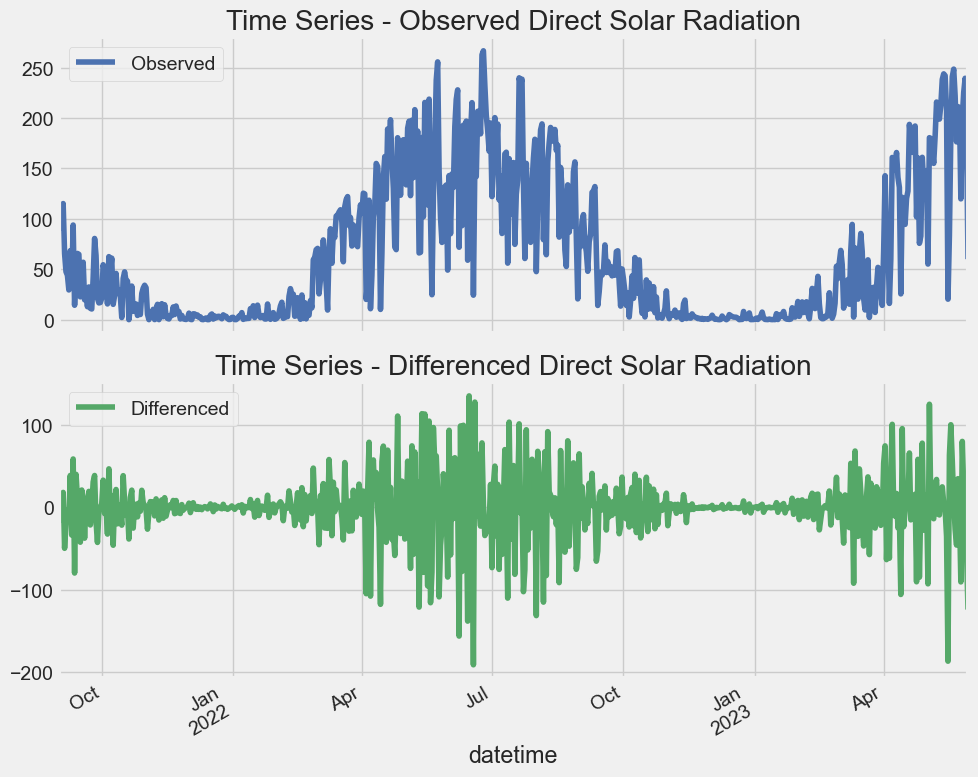

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
target.plot(title='Time Series - Observed Direct Solar Radiation', ax=ax1, color=deep_colors[0], label='Observed')
target_diff.plot(title='Time Series - Differenced Direct Solar Radiation', ax=ax2, color=deep_colors[1], label='Differenced')
ax1.legend()
ax2.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

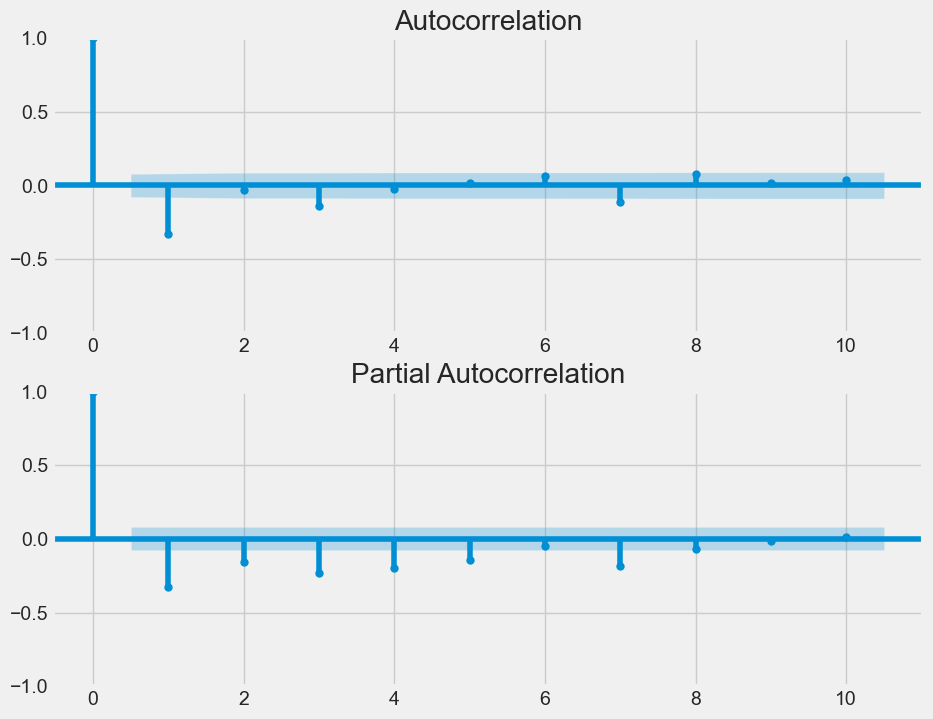

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(target_diff[1:], lags=10, ax=ax1)
plot_pacf(target_diff[1:], lags=10, ax=ax2)
plt.show()

In [57]:
def optimize_SARIMAX(
        endog: Union[pd.Series, list], exog: Union[pd.Series, list],
        order_list: list, d: int,
        # D: int, s: int
) -> pd.DataFrame:

    results = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for order in notebook.tqdm(order_list):
            try:
                model = SARIMAX(
                    endog,
                    exog,
                    order=(order[0], d, order[1]),
                    # seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue

            aic = model.aic
            results.append([order, aic])

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']

        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        return result_df

In [58]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
d = 1

SARIMAX_order_list = list(product(ps, qs))
SARIMAX_result_df = optimize_SARIMAX(target, exog, SARIMAX_order_list, d)
SARIMAX_result_df.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(p,q)          AIC
0  (2, 2)  5653.455861
1  (3, 1)  5654.296332
2  (4, 2)  5654.746607
3  (0, 3)  5654.759564
4  (1, 4)  5655.253394

In [59]:
SARIMAX_model = SARIMAX(
    endog=target,
    exog=exog,
    order=(SARIMAX_result_df.iloc[0,0][0], d, SARIMAX_result_df.iloc[0,0][1]),
    simple_differencing=False
)
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)
print(SARIMAX_model_fit.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                 SARIMAX Results                                  
Dep. Variable:     direct_solar_radiation   No. Observations:                  637
Model:                   SARIMAX(2, 1, 2)   Log Likelihood               -2813.728
Date:                    Fri, 22 Dec 2023   AIC                           5653.456
Time:                            05:40:15   BIC                           5711.373
Sample:                        09-01-2021   HQIC                          5675.943
                             - 05-30-2023                                         
Covariance Type:                      opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
temperature           7.1190      0.929      7.666      0.000       5.299       8.939
dewpoint             -5.4229      0.823     -6.591      0.000      -7.035     

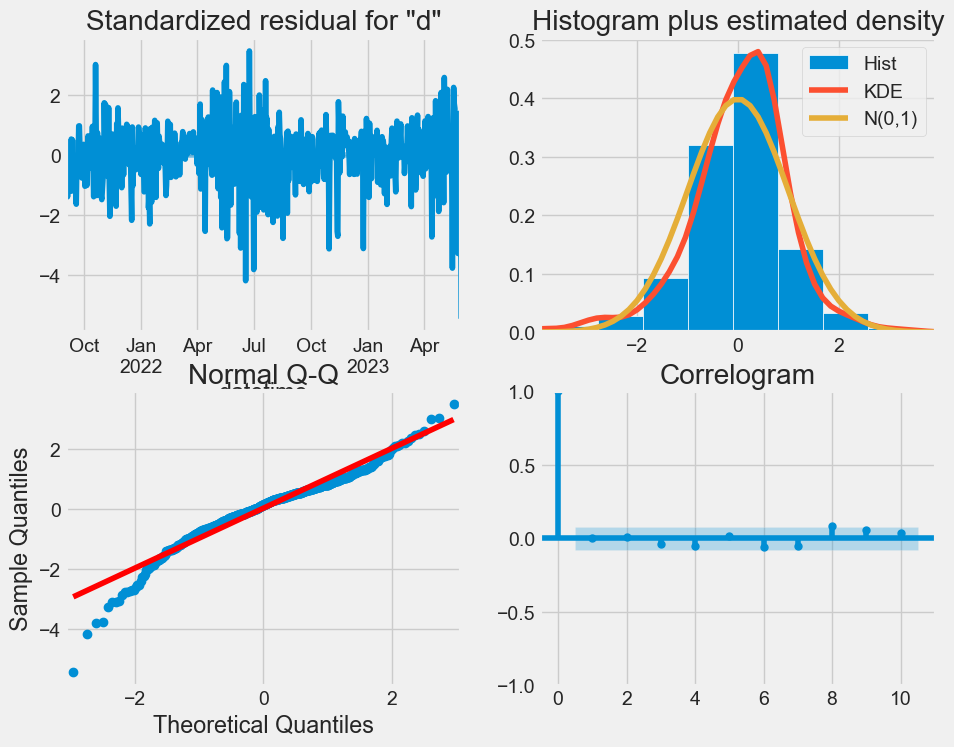

In [60]:
SARIMAX_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [61]:
residuals = SARIMAX_model_fit.resid
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_df

lb_stat  lb_pvalue
1   0.014211   0.905108
2   0.173051   0.917112
3   0.571190   0.902995
4   3.019849   0.554509
5   3.103231   0.684074
6   4.339718   0.630806
7   6.157211   0.521517
8   7.488915   0.484914
9   7.608162   0.574064
10  8.273039   0.602186